# Word2Bits in TensorFlow

This notebook reproduces the results of the [Word2Bits paper][1] (Lam, 2018) by applying the least necessary amount of changes to the [basic word2vec example][2] from a [TensorFlow word tutorial][3]

 [1]: https://arxiv.org/abs/1803.05651 (Word2Bits-Quantized Word Vectors)
 [2]: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
 [3]: https://www.tensorflow.org/tutorials/representation/word2vec (Vector Representations of Words)

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import sys
import argparse
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from tensorflow.contrib.tensorboard.plugins import projector

# Give a folder path as an argument with '--log_dir' to save
# TensorBoard summaries. Default is a log folder in current directory.
current_path = os.path.dirname(os.path.realpath(sys.argv[0]))

parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(current_path, 'log'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()

# Create the directory for TensorBoard variables if there is not.
if not os.path.exists(FLAGS.log_dir):
    os.makedirs(FLAGS.log_dir)

## **Step 1:** Download the data

In [4]:
url = 'http://mattmahoney.net/dc/'


# pylint: disable=redefined-outer-name
def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  local_filename = os.path.join('.', filename)
  if not os.path.exists(local_filename):
    local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                   local_filename)
  statinfo = os.stat(local_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception('Failed to verify ' + local_filename +
                    '. Can you get to it with a browser?')
  return local_filename


filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a list of strings.

In [5]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words."""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data


vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 17005207


## **Step 2:** Build the dictionary and replace rare words with UNK token.

The Word2Bits paper [completely removes][1] rare words, whereas we replace them with a UNK token. The Word2Bits paper also keeps all words whose [frequency is larger than 5][2] and whose [frequency is larger than 1 when the hash table is rehashed][3], which amounts to a dictionary of [71,291 words][4]~~, whereas we only keep the 50,000 most frequent words in the dictionary~~.

 [1]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L398
 [2]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L225
 [3]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L248
 [4]: https://pastebin.com/PaYruqAu

In [6]:
vocabulary_size = len(set(vocabulary)) + 1


def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary


# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 0], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## **Step 3:** Function to generate a training batch for the skip-gram model.

The Word2Bits paper [computes gradients for every training sample][1], whereas we use minibatches. The Word2Bits paper also uses the CBOW model, whereas we use the Skip-gram model. The Word2Bits model also [subsamples the input data][2] with probability $1 - \frac{1\text{E}-4}{f(w_i)}$ (see [Mikolov13Distributed][3], Section 2.3), whereas we subsample the context words uniformly.

 [1]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L424
 [2]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L401
 [3]: http://papers.nips.cc/paper/5021-distributed-representations-of-words-andphrases (Distributed representations of words and phrases and their compositionality)

In [46]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
    print('Finished an epoch.')
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
      print('Finished an epoch.')
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels


batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
reverse_dictionary[labels[i, 0]])

312 works -> 2 of
312 works -> 2017 similarly
2 of -> 433 art
2 of -> 312 works
433 art -> 26 are
433 art -> 2 of
26 are -> 2177 rarely
26 are -> 433 art


## **Step 4:** Build and train a skip-gram model.
The Word2Bits paper [uses negative sampling][1] (see [Mikolov13Distributed][2], Section 2.2), whereas we use the more general technique of [Noise Contrastive Estimation (NCE)][3]. ~~The Word2bits paper also [uses a learning rate of $0.05$ linearly decayed to $0.0001\cdot 0.05$][4]. The Word2bits paper also [quantizes the word embeddings][5].~~

 [1]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L456
 [2]: http://papers.nips.cc/paper/5021-distributed-representations-of-words-andphrases (Distributed representations of words and phrases and their compositionality)
 [3]: https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss (tf.nn.nce_loss)
 [4]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L391
 [5]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L86

In [47]:
from math import ceil
batch_size = 128
embedding_size = 600  # Dimension of the embedding vector.
skip_window = 10  # How many words to consider left and right.
num_skips = 16  # How many times to reuse an input to generate a label.
num_sampled = 24  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

num_epochs = 10
num_steps = int(ceil(num_epochs * len(data) / (batch_size // num_skips)))

graph = tf.Graph()

def quantize(x):
    return tf.scalar_mul(1/3, tf.sign(x))

@tf.custom_gradient
def quantize_with_straight_through_gradient(x):
    return quantize(x), tf.identity

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/gpu:0'):
    # Look up embeddings for inputs.
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)
      quantized_embed = quantize_with_straight_through_gradient(embed)


    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=quantized_embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    global_step = tf.Variable(0, name='global_step', trainable=False, dtype=tf.int32)
    increment_global_step_op = tf.assign(global_step, global_step+1)
    learning_rate = tf.math.maximum(0.05 * 0.0001, tf.train.polynomial_decay(0.05, global_step, num_steps, 0.0))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  quantized_embeddings = quantize(embeddings)
  normalized_embeddings = quantized_embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
  saver = tf.train.Saver()

## **Step 5**: Begin training.

In [48]:
with tf.Session(graph=graph) as session:
  # Open a writer to write summaries.
  writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    session.run(increment_global_step_op)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
    writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
    if step == (num_steps - 1):
      writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ' (', 100 * step / num_steps, '%): ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 100000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = quantized_embeddings.eval()

  # Write corresponding labels for the embeddings.
  with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
    for i in xrange(vocabulary_size):
      f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
  saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
  config = projector.ProjectorConfig()
  embedding_conf = config.embeddings.add()
  embedding_conf.tensor_name = embeddings.name
  embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
  projector.visualize_embeddings(writer, config)

writer.close()

Initialized
Average loss at step  0  ( 0.0 %):  138.54238891601562
Nearest to time: breda, mausoleums, bieta, cybermen, starwisp, affonso, levellers, ossicorns,
Nearest to that: beshalla, areopagus, leapling, shrill, situated, phoneline, shunka, msfs,
Nearest to after: mphahlele, congreso, mahican, governess, finances, cytidine, akafellas, ckisch,
Nearest to and: snmp, marshaling, aroostook, trihydrate, blackwater, nlandsp, antsiranana, maximizes,
Nearest to first: fustibus, ausare, pachyderm, kristine, garn, plumbism, carbondioxide, icht,
Nearest to system: canslim, ynambu, mislaid, verkholensk, haute, sadami, amygdaloidalnone, vaagima,
Nearest to s: petals, oldebarneveldt, vencer, freethinking, randall, entailed, evenimentul, archery,
Nearest to had: aftershock, allayed, nordschleswig, amerikanischdeutsch, thorney, underflow, varjag, presburger,
Nearest to no: sixtieth, koib, blackrose, cryotech, quattrovalvole, theologumenon, faca, knoll,
Nearest to UNK: coff, snuffle, yireh, nomoth

Average loss at step  158000  ( 0.743301734071 %):  44.689533648252485
Average loss at step  160000  ( 0.752710616781 %):  43.88590106785298
Average loss at step  162000  ( 0.762119499491 %):  44.265251904010775
Average loss at step  164000  ( 0.7715283822 %):  44.389667433023455
Average loss at step  166000  ( 0.78093726491 %):  43.89088334339857
Average loss at step  168000  ( 0.79034614762 %):  42.06708736562729
Average loss at step  170000  ( 0.79975503033 %):  42.71693684089184
Average loss at step  172000  ( 0.80916391304 %):  41.227666001558305
Average loss at step  174000  ( 0.818572795749 %):  41.57241562271118
Average loss at step  176000  ( 0.827981678459 %):  43.45941582632065
Average loss at step  178000  ( 0.837390561169 %):  41.53811640870571
Average loss at step  180000  ( 0.846799443879 %):  40.42329108405113
Average loss at step  182000  ( 0.856208326588 %):  38.09533607625961
Average loss at step  184000  ( 0.865617209298 %):  38.606223023414614
Average loss at step 

Average loss at step  324000  ( 1.52423899898 %):  28.413585329651834
Average loss at step  326000  ( 1.53364788169 %):  29.346238248109817
Average loss at step  328000  ( 1.5430567644 %):  26.407209411263466
Average loss at step  330000  ( 1.55246564711 %):  24.70124942469597
Average loss at step  332000  ( 1.56187452982 %):  26.089413627266882
Average loss at step  334000  ( 1.57128341253 %):  23.128150448679925
Average loss at step  336000  ( 1.58069229524 %):  27.844200251579284
Average loss at step  338000  ( 1.59010117795 %):  26.511942344665528
Average loss at step  340000  ( 1.59951006066 %):  26.867212070703506
Average loss at step  342000  ( 1.60891894337 %):  26.516802474409342
Average loss at step  344000  ( 1.61832782608 %):  27.451154095053674
Average loss at step  346000  ( 1.62773670879 %):  26.872736500263215
Average loss at step  348000  ( 1.6371455915 %):  25.334982990264894
Average loss at step  350000  ( 1.64655447421 %):  22.835146428108214
Average loss at step  3

Nearest to during: our, specific, mass, past, band, moved, eventually, bank,
Nearest to with: co, bank, changes, band, our, moved, speed, playing,
Nearest to been: past, co, band, bank, our, moved, mass, problems,
Nearest to other: co, band, bank, changes, our, moved, speed, mass,
Average loss at step  502000  ( 2.36162956015 %):  19.00651817882061
Average loss at step  504000  ( 2.37103844286 %):  18.721613804221153
Average loss at step  506000  ( 2.38044732557 %):  19.945297352313997
Average loss at step  508000  ( 2.38985620828 %):  19.61095961546898
Average loss at step  510000  ( 2.39926509099 %):  18.70373997712135
Average loss at step  512000  ( 2.4086739737 %):  17.881039651751518
Average loss at step  514000  ( 2.41808285641 %):  17.757205429673196
Average loss at step  516000  ( 2.42749173912 %):  16.99782810783386
Average loss at step  518000  ( 2.43690062183 %):  18.572802804231642
Average loss at step  520000  ( 2.44630950454 %):  18.62525458097458
Average loss at step  52

Average loss at step  698000  ( 3.28370006571 %):  15.234231746673585
Average loss at step  700000  ( 3.29310894842 %):  14.40320482456684
Nearest to time: past, note, justice, date, online, problems, bank, band,
Nearest to that: past, justice, date, online, bank, note, band, our,
Nearest to after: bank, date, enough, past, justice, speed, our, band,
Nearest to and: past, bank, justice, date, online, our, enough, changes,
Nearest to first: online, past, justice, date, our, changes, bank, note,
Nearest to system: co, justice, online, note, band, date, african, features,
Nearest to s: past, bank, justice, date, enough, length, speed, online,
Nearest to had: past, bank, justice, date, online, our, enough, changes,
Nearest to no: co, date, note, online, bank, justice, our, specific,
Nearest to UNK: coff, snuffle, yireh, nomothetic, westmacott, sotamies, domesticating, iliyyat,
Nearest to this: past, justice, date, online, bank, note, band, our,
Nearest to by: past, bank, date, justice, onl

Average loss at step  866000  ( 4.07404621333 %):  11.927848515152931
Average loss at step  868000  ( 4.08345509604 %):  12.026707916378975
Average loss at step  870000  ( 4.09286397875 %):  12.332123781323434
Average loss at step  872000  ( 4.10227286146 %):  12.830104216635227
Average loss at step  874000  ( 4.11168174417 %):  12.032299434661866
Average loss at step  876000  ( 4.12109062688 %):  13.117778411805629
Average loss at step  878000  ( 4.13049950959 %):  15.246917644143105
Average loss at step  880000  ( 4.1399083923 %):  12.182402020573615
Average loss at step  882000  ( 4.14931727501 %):  12.061425591945648
Average loss at step  884000  ( 4.15872615771 %):  13.632956851243973
Average loss at step  886000  ( 4.16813504042 %):  12.803733228206635
Average loss at step  888000  ( 4.17754392313 %):  13.13628330719471
Average loss at step  890000  ( 4.18695280584 %):  14.363191173911094
Average loss at step  892000  ( 4.19636168855 %):  11.405531455278396
Average loss at step  

Average loss at step  1032000  ( 4.85498347824 %):  13.412893190741539
Average loss at step  1034000  ( 4.86439236095 %):  11.715174522161483
Average loss at step  1036000  ( 4.87380124366 %):  11.56648989379406
Average loss at step  1038000  ( 4.88321012637 %):  11.881734284758569
Average loss at step  1040000  ( 4.89261900908 %):  11.709155728518963
Average loss at step  1042000  ( 4.90202789179 %):  24.05914175885916
Average loss at step  1044000  ( 4.9114367745 %):  21.353264510512354
Average loss at step  1046000  ( 4.92084565721 %):  11.659249990701676
Average loss at step  1048000  ( 4.93025453992 %):  11.271500393748283
Average loss at step  1050000  ( 4.93966342263 %):  11.525231975674629
Average loss at step  1052000  ( 4.94907230533 %):  12.525761550307275
Average loss at step  1054000  ( 4.95848118804 %):  10.585920234680176
Average loss at step  1056000  ( 4.96789007075 %):  11.237179211497306
Average loss at step  1058000  ( 4.97729895346 %):  11.812391567349433
Average l

Average loss at step  1202000  ( 5.65473850857 %):  11.23360828578472
Average loss at step  1204000  ( 5.66414739128 %):  11.324254369139672
Average loss at step  1206000  ( 5.67355627399 %):  12.126379646778107
Average loss at step  1208000  ( 5.6829651567 %):  11.41707397699356
Average loss at step  1210000  ( 5.69237403941 %):  10.922464611887932
Average loss at step  1212000  ( 5.70178292212 %):  11.249587629258633
Average loss at step  1214000  ( 5.71119180483 %):  10.441360520362855
Average loss at step  1216000  ( 5.72060068754 %):  11.556072680443526
Average loss at step  1218000  ( 5.73000957025 %):  11.487013942837715
Average loss at step  1220000  ( 5.73941845295 %):  10.893918831110001
Average loss at step  1222000  ( 5.74882733566 %):  9.40010725557804
Average loss at step  1224000  ( 5.75823621837 %):  10.666422678232193
Average loss at step  1226000  ( 5.76764510108 %):  10.77842661100626
Average loss at step  1228000  ( 5.77705398379 %):  10.49478993654251
Average loss 

Nearest to first: changes, effect, earth, our, online, de, co, band,
Nearest to system: low, online, past, earth, changes, light, our, de,
Nearest to s: earth, changes, effect, co, de, our, online, problems,
Nearest to had: changes, effect, earth, our, online, de, co, band,
Nearest to no: low, earth, changes, our, online, de, co, band,
Nearest to UNK: coff, snuffle, yireh, westmacott, nomothetic, domesticating, iliyyat, sotamies,
Nearest to this: effect, earth, changes, our, online, de, band, light,
Nearest to by: changes, effect, earth, our, online, de, co, band,
Nearest to during: changes, earth, effect, our, above, online, specific, de,
Nearest to with: effect, earth, changes, our, online, de, band, light,
Nearest to been: effect, earth, changes, our, online, de, band, light,
Nearest to other: effect, earth, changes, our, online, de, band, light,
Average loss at step  1402000  ( 6.59562677954 %):  9.985250194907188
Average loss at step  1404000  ( 6.60503566225 %):  9.27701753425598

Average loss at step  1580000  ( 7.43301734071 %):  8.93316562283039
Average loss at step  1582000  ( 7.44242622342 %):  9.483595916152
Average loss at step  1584000  ( 7.45183510613 %):  9.334533758819104
Average loss at step  1586000  ( 7.46124398884 %):  8.816363139271736
Average loss at step  1588000  ( 7.47065287155 %):  9.431235088586806
Average loss at step  1590000  ( 7.48006175426 %):  8.549159395754337
Average loss at step  1592000  ( 7.48947063697 %):  10.879835149168969
Average loss at step  1594000  ( 7.49887951968 %):  9.5322071531415
Average loss at step  1596000  ( 7.50828840239 %):  9.71607662844658
Average loss at step  1598000  ( 7.5176972851 %):  8.6811205701828
Average loss at step  1600000  ( 7.52710616781 %):  8.493732218384743
Nearest to time: changes, effect, data, our, online, earth, open, band,
Nearest to that: changes, effect, data, our, online, earth, open, band,
Nearest to after: changes, data, effect, style, our, online, writing, earth,
Nearest to and: ch

Average loss at step  1746000  ( 8.21395460562 %):  9.969745735645294
Average loss at step  1748000  ( 8.22336348833 %):  9.679833205461502
Average loss at step  1750000  ( 8.23277237104 %):  8.752648005485534
Average loss at step  1752000  ( 8.24218125375 %):  10.047258132815362
Average loss at step  1754000  ( 8.25159013646 %):  8.871839968323707
Average loss at step  1756000  ( 8.26099901917 %):  10.459214198112488
Average loss at step  1758000  ( 8.27040790188 %):  11.93283154988289
Average loss at step  1760000  ( 8.27981678459 %):  8.99136452305317
Average loss at step  1762000  ( 8.2892256673 %):  10.386542333722115
Average loss at step  1764000  ( 8.29863455001 %):  7.563177586913109
Average loss at step  1766000  ( 8.30804343272 %):  12.934239752292633
Average loss at step  1768000  ( 8.31745231543 %):  8.647368911385536
Average loss at step  1770000  ( 8.32686119814 %):  10.3208007979393
Average loss at step  1772000  ( 8.33627008085 %):  9.277601343035698
Average loss at ste

Average loss at step  1910000  ( 8.98548298782 %):  8.268924954295159
Average loss at step  1912000  ( 8.99489187053 %):  8.862117800951005
Average loss at step  1914000  ( 9.00430075324 %):  8.350543172597884
Average loss at step  1916000  ( 9.01370963595 %):  9.293608864784241
Average loss at step  1918000  ( 9.02311851866 %):  8.82200668925047
Average loss at step  1920000  ( 9.03252740137 %):  7.806403379917144
Average loss at step  1922000  ( 9.04193628408 %):  8.855216878294945
Average loss at step  1924000  ( 9.05134516679 %):  8.064060420751572
Average loss at step  1926000  ( 9.0607540495 %):  8.183055172562598
Average loss at step  1928000  ( 9.07016293221 %):  7.606356554150581
Average loss at step  1930000  ( 9.07957181492 %):  9.2684501080513
Average loss at step  1932000  ( 9.08898069763 %):  9.55113230764866
Average loss at step  1934000  ( 9.09838958034 %):  8.481381089568139
Average loss at step  1936000  ( 9.10779846305 %):  8.471610538721084
Average loss at step  193

Nearest to first: programs, speed, having, union, next, film, changes, result,
Nearest to system: having, study, film, forces, groups, our, along, back,
Nearest to s: changes, our, result, christian, person, programs, present, speed,
Nearest to had: our, person, small, having, next, film, forces, changes,
Nearest to no: small, study, changes, christian, along, person, having, film,
Nearest to UNK: coff, snuffle, yireh, westmacott, nomothetic, domesticating, iliyyat, kuropka,
Nearest to this: our, person, small, having, next, film, forces, changes,
Nearest to by: changes, our, result, christian, person, programs, present, speed,
Nearest to during: changes, next, small, above, house, story, film, forces,
Nearest to with: our, person, small, having, next, film, forces, changes,
Nearest to been: our, person, small, having, next, film, forces, changes,
Nearest to other: our, person, small, having, next, film, forces, changes,
Average loss at step  2102000  ( 9.88873572796 %):  7.90644420421

Average loss at step  2274000  ( 10.697899641 %):  8.448288448810578
Average loss at step  2276000  ( 10.7073085237 %):  8.41412461847067
Average loss at step  2278000  ( 10.7167174064 %):  8.41157411903143
Average loss at step  2280000  ( 10.7261262891 %):  10.263368866801262
Average loss at step  2282000  ( 10.7355351718 %):  7.582199789762497
Average loss at step  2284000  ( 10.7449440545 %):  8.439086436271667
Average loss at step  2286000  ( 10.7543529373 %):  8.312964787483216
Average loss at step  2288000  ( 10.76376182 %):  8.817941713273525
Average loss at step  2290000  ( 10.7731707027 %):  9.107010046362877
Average loss at step  2292000  ( 10.7825795854 %):  8.624060262799263
Average loss at step  2294000  ( 10.7919884681 %):  6.933744826555252
Average loss at step  2296000  ( 10.8013973508 %):  8.590560978055
Average loss at step  2298000  ( 10.8108062335 %):  6.95377696877718
Average loss at step  2300000  ( 10.8202151162 %):  8.20871075773239
Nearest to time: our, film, g

Average loss at step  2440000  ( 11.4788369059 %):  8.019472171127797
Average loss at step  2442000  ( 11.4882457886 %):  6.981554652273655
Average loss at step  2444000  ( 11.4976546713 %):  7.654551002323627
Average loss at step  2446000  ( 11.507063554 %):  8.683389767289162
Average loss at step  2448000  ( 11.5164724367 %):  7.4610357761383055
Average loss at step  2450000  ( 11.5258813195 %):  8.490632879257202
Average loss at step  2452000  ( 11.5352902022 %):  8.63471583878994
Average loss at step  2454000  ( 11.5446990849 %):  7.654659677267075
Average loss at step  2456000  ( 11.5541079676 %):  7.151688384771347
Average loss at step  2458000  ( 11.5635168503 %):  6.8925887799263
Average loss at step  2460000  ( 11.572925733 %):  7.296580188632012
Average loss at step  2462000  ( 11.5823346157 %):  8.21851300728321
Average loss at step  2464000  ( 11.5917434984 %):  8.677495913743973
Average loss at step  2466000  ( 11.6011523811 %):  7.688503183186055
Average loss at step  246

Average loss at step  2604000  ( 12.2503652881 %):  8.108891528606415
Average loss at step  2606000  ( 12.2597741708 %):  7.161794558227062
Average loss at step  2608000  ( 12.2691830535 %):  7.233663187086583
Average loss at step  2610000  ( 12.2785919362 %):  7.450342000365257
Average loss at step  2612000  ( 12.2880008189 %):  7.998615145087242
Average loss at step  2614000  ( 12.2974097017 %):  8.264908764839172
Average loss at step  2616000  ( 12.3068185844 %):  5.8010516260862355
Average loss at step  2618000  ( 12.3162274671 %):  6.784301395058632
Average loss at step  2620000  ( 12.3256363498 %):  6.6183220306634905
Average loss at step  2622000  ( 12.3350452325 %):  6.895512343645096
Average loss at step  2624000  ( 12.3444541152 %):  8.113855945706367
Average loss at step  2626000  ( 12.3538629979 %):  7.125096031308174
Average loss at step  2628000  ( 12.3632718806 %):  6.948672819256783
Average loss at step  2630000  ( 12.3726807633 %):  6.891962956130505
Average loss at st

Nearest to first: us, date, our, present, changes, due, study, above,
Nearest to system: our, due, us, present, programs, forces, still, changes,
Nearest to s: us, programs, date, present, our, around, next, changes,
Nearest to had: us, our, present, changes, due, study, date, individual,
Nearest to no: our, changes, still, possible, us, present, exist, due,
Nearest to UNK: coff, snuffle, yireh, westmacott, nomothetic, iliyyat, kuropka, sotamies,
Nearest to this: our, us, present, programs, changes, still, due, possible,
Nearest to by: us, our, present, programs, changes, due, study, above,
Nearest to during: changes, us, study, above, our, present, next, still,
Nearest to with: programs, our, still, us, law, present, online, cause,
Nearest to been: our, us, present, changes, still, due, possible, study,
Nearest to other: our, still, us, present, programs, changes, due, possible,
Average loss at step  2802000  ( 13.1818446764 %):  7.784292571544647
Average loss at step  2804000  ( 13.1

Average loss at step  2978000  ( 14.0098263548 %):  7.434931816220283
Average loss at step  2980000  ( 14.0192352375 %):  7.953499352097511
Average loss at step  2982000  ( 14.0286441203 %):  7.094806698322296
Average loss at step  2984000  ( 14.038053003 %):  8.702250672698021
Average loss at step  2986000  ( 14.0474618857 %):  6.082680910348892
Average loss at step  2988000  ( 14.0568707684 %):  7.490572171151638
Average loss at step  2990000  ( 14.0662796511 %):  6.634444842576981
Average loss at step  2992000  ( 14.0756885338 %):  6.732524751782417
Average loss at step  2994000  ( 14.0850974165 %):  6.5177566775679585
Average loss at step  2996000  ( 14.0945062992 %):  7.274413666009903
Average loss at step  2998000  ( 14.1039151819 %):  7.669073705673218
Average loss at step  3000000  ( 14.1133240646 %):  6.501156295776367
Nearest to time: law, our, present, next, us, changes, forces, exist,
Nearest to that: our, law, present, next, programs, forces, groups, us,
Nearest to after: 

Average loss at step  3144000  ( 14.7907636197 %):  7.213534619688987
Average loss at step  3146000  ( 14.8001725025 %):  7.222599071860313
Average loss at step  3148000  ( 14.8095813852 %):  6.9904191945791245
Average loss at step  3150000  ( 14.8189902679 %):  6.620905545592308
Average loss at step  3152000  ( 14.8283991506 %):  6.786495191812516
Average loss at step  3154000  ( 14.8378080333 %):  6.754074344396591
Average loss at step  3156000  ( 14.847216916 %):  6.984471025764942
Average loss at step  3158000  ( 14.8566257987 %):  8.623572731733322
Average loss at step  3160000  ( 14.8660346814 %):  7.112424295425415
Average loss at step  3162000  ( 14.8754435641 %):  6.834825848817825
Average loss at step  3164000  ( 14.8848524468 %):  7.831699625372886
Average loss at step  3166000  ( 14.8942613296 %):  8.257007592916489
Average loss at step  3168000  ( 14.9036702123 %):  14.728665563344956
Average loss at step  3170000  ( 14.913079095 %):  13.080935509562492
Average loss at ste

Average loss at step  3312000  ( 15.5811097674 %):  7.006214178681374
Average loss at step  3314000  ( 15.5905186501 %):  7.7174250882864
Average loss at step  3316000  ( 15.5999275328 %):  7.848469202041626
Average loss at step  3318000  ( 15.6093364155 %):  6.633875691950321
Average loss at step  3320000  ( 15.6187452982 %):  6.9857480866909025
Average loss at step  3322000  ( 15.6281541809 %):  7.203091351985932
Average loss at step  3324000  ( 15.6375630636 %):  8.23659497177601
Average loss at step  3326000  ( 15.6469719463 %):  6.908265558838845
Average loss at step  3328000  ( 15.656380829 %):  7.41928336083889
Average loss at step  3330000  ( 15.6657897118 %):  7.504731680750847
Average loss at step  3332000  ( 15.6751985945 %):  7.594413271188736
Average loss at step  3334000  ( 15.6846074772 %):  7.271348147273064
Average loss at step  3336000  ( 15.6940163599 %):  6.896636393070221
Average loss at step  3338000  ( 15.7034252426 %):  7.80859423327446
Average loss at step  334

Nearest to with: present, having, changes, law, programs, itself, online, forces,
Nearest to been: changes, problems, having, small, online, country, itself, above,
Nearest to other: changes, law, person, game, small, problems, itself, having,
Average loss at step  3502000  ( 16.4749536248 %):  7.24119825053215
Average loss at step  3504000  ( 16.4843625075 %):  7.546877834200859
Average loss at step  3506000  ( 16.4937713902 %):  6.485767516553402
Average loss at step  3508000  ( 16.5031802729 %):  6.171406748294831
Average loss at step  3510000  ( 16.5125891556 %):  6.880928978681564
Average loss at step  3512000  ( 16.5219980383 %):  7.24981052082777
Average loss at step  3514000  ( 16.5314069211 %):  6.751139844655991
Average loss at step  3516000  ( 16.5408158038 %):  6.990632983446122
Average loss at step  3518000  ( 16.5502246865 %):  6.85252068066597
Average loss at step  3520000  ( 16.5596335692 %):  6.635104245126247
Average loss at step  3522000  ( 16.5690424519 %):  5.79275

Average loss at step  3694000  ( 17.3782063649 %):  7.039868607640266
Average loss at step  3696000  ( 17.3876152476 %):  6.71779186463356
Average loss at step  3698000  ( 17.3970241303 %):  6.816744865417481
Average loss at step  3700000  ( 17.4064330131 %):  6.972065776586533
Nearest to time: changes, small, base, high, above, game, itself, law,
Nearest to that: itself, changes, programs, still, set, above, small, law,
Nearest to after: date, having, changes, played, due, next, back, itself,
Nearest to and: changes, itself, high, programs, control, date, above, country,
Nearest to first: changes, date, programs, itself, having, high, small, played,
Nearest to system: present, changes, due, still, small, having, high, widely,
Nearest to s: changes, date, us, itself, live, online, law, country,
Nearest to had: changes, small, played, still, control, game, sea, high,
Nearest to no: changes, present, small, game, problems, writing, law, tribes,
Nearest to UNK: coff, snuffle, nomothetic, 

Average loss at step  3860000  ( 18.1591436298 %):  6.775610408425331
Average loss at step  3862000  ( 18.1685525126 %):  7.241424392700195
Average loss at step  3864000  ( 18.1779613953 %):  10.161100895762443
Average loss at step  3866000  ( 18.187370278 %):  6.452157816231251
Average loss at step  3868000  ( 18.1967791607 %):  7.4932691641449924
Average loss at step  3870000  ( 18.2061880434 %):  7.003122236013413
Average loss at step  3872000  ( 18.2155969261 %):  6.623642490148544
Average loss at step  3874000  ( 18.2250058088 %):  7.39668210875988
Average loss at step  3876000  ( 18.2344146915 %):  6.916672388315201
Average loss at step  3878000  ( 18.2438235742 %):  7.13503876721859
Average loss at step  3880000  ( 18.2532324569 %):  7.193185429692268
Average loss at step  3882000  ( 18.2626413396 %):  7.178111248850822
Average loss at step  3884000  ( 18.2720502224 %):  9.846020320177079
Average loss at step  3886000  ( 18.2814591051 %):  6.117786234557629
Average loss at step 

Average loss at step  4024000  ( 18.930672012 %):  6.635776968121529
Average loss at step  4026000  ( 18.9400808948 %):  5.968381415963173
Average loss at step  4028000  ( 18.9494897775 %):  6.6568435810804365
Average loss at step  4030000  ( 18.9588986602 %):  6.936353705763817
Average loss at step  4032000  ( 18.9683075429 %):  7.076005906820297
Average loss at step  4034000  ( 18.9777164256 %):  6.559312484562397
Average loss at step  4036000  ( 18.9871253083 %):  6.3010592259168625
Average loss at step  4038000  ( 18.996534191 %):  6.637021186769009
Average loss at step  4040000  ( 19.0059430737 %):  6.334002078413963
Average loss at step  4042000  ( 19.0153519564 %):  7.341459461212159
Average loss at step  4044000  ( 19.0247608391 %):  6.209566271305084
Average loss at step  4046000  ( 19.0341697218 %):  6.1897947562932965
Average loss at step  4048000  ( 19.0435786046 %):  6.310075207710266
Average loss at step  4050000  ( 19.0529874873 %):  6.509790151119232
Average loss at ste

Nearest to with: programs, small, having, reason, game, above, already, set,
Nearest to been: present, problems, base, game, small, above, already, individual,
Nearest to other: small, law, programs, few, person, game, our, little,
Average loss at step  4202000  ( 19.7680625732 %):  6.049661517262459
Average loss at step  4204000  ( 19.7774714559 %):  6.859571981549263
Average loss at step  4206000  ( 19.7868803386 %):  5.926057899475098
Average loss at step  4208000  ( 19.7962892213 %):  5.364386009454727
Average loss at step  4210000  ( 19.805698104 %):  7.290960753560066
Average loss at step  4212000  ( 19.8151069868 %):  7.185769100904465
Average loss at step  4214000  ( 19.8245158695 %):  6.5379931268692015
Average loss at step  4216000  ( 19.8339247522 %):  6.911410856485367
Average loss at step  4218000  ( 19.8433336349 %):  7.2684978724718095
Average loss at step  4220000  ( 19.8527425176 %):  5.981162379384041
Average loss at step  4222000  ( 19.8621514003 %):  6.5788716415166

Average loss at step  4394000  ( 20.6713153133 %):  6.876008353233337
Average loss at step  4396000  ( 20.6807241961 %):  7.557335469245911
Average loss at step  4398000  ( 20.6901330788 %):  6.912121733605861
Average loss at step  4400000  ( 20.6995419615 %):  7.107772405862808
Nearest to time: changes, already, game, writing, small, able, country, present,
Nearest to that: changes, set, country, date, base, individual, already, small,
Nearest to after: changes, having, date, played, genetic, next, great, country,
Nearest to and: country, programs, base, present, date, christian, law, players,
Nearest to first: base, second, back, played, global, stories, small, modern,
Nearest to system: changes, back, still, present, followed, small, series, beyond,
Nearest to s: date, bank, due, present, base, back, market, law,
Nearest to had: changes, small, played, present, already, programs, date, provided,
Nearest to no: changes, beyond, become, directly, problems, set, widely, game,
Nearest t

Average loss at step  4556000  ( 21.4334348128 %):  5.948506670832634
Average loss at step  4558000  ( 21.4428436955 %):  5.530172158420086
Average loss at step  4560000  ( 21.4522525783 %):  6.020990899562836
Average loss at step  4562000  ( 21.461661461 %):  5.706853787660599
Average loss at step  4564000  ( 21.4710703437 %):  6.046857372283935
Average loss at step  4566000  ( 21.4804792264 %):  6.5202206361293795
Average loss at step  4568000  ( 21.4898881091 %):  5.380287581324577
Average loss at step  4570000  ( 21.4992969918 %):  6.635926373779774
Average loss at step  4572000  ( 21.5087058745 %):  6.476252182602883
Average loss at step  4574000  ( 21.5181147572 %):  6.38511652469635
Average loss at step  4576000  ( 21.5275236399 %):  6.907374320030212
Average loss at step  4578000  ( 21.5369325226 %):  6.56976187312603
Average loss at step  4580000  ( 21.5463414054 %):  6.076181387066841
Average loss at step  4582000  ( 21.5557502881 %):  5.845183512926102
Average loss at step  

Average loss at step  4718000  ( 22.1955543123 %):  5.5162165132761
Average loss at step  4720000  ( 22.204963195 %):  5.999159422755241
Average loss at step  4722000  ( 22.2143720777 %):  6.4065486179590225
Average loss at step  4724000  ( 22.2237809605 %):  6.189725909590721
Average loss at step  4726000  ( 22.2331898432 %):  7.435133208751679
Average loss at step  4728000  ( 22.2425987259 %):  5.5100261614322665
Average loss at step  4730000  ( 22.2520076086 %):  6.917993768692017
Average loss at step  4732000  ( 22.2614164913 %):  5.808040937006473
Average loss at step  4734000  ( 22.270825374 %):  6.316068727016449
Average loss at step  4736000  ( 22.2802342567 %):  6.142401561141014
Average loss at step  4738000  ( 22.2896431394 %):  6.3093220825195315
Average loss at step  4740000  ( 22.2990520221 %):  6.711498850822449
Average loss at step  4742000  ( 22.3084609048 %):  4.8984566845893855
Average loss at step  4744000  ( 22.3178697876 %):  5.780887226223945
Average loss at step

Nearest to with: market, changes, earth, few, instead, free, already, programs,
Nearest to been: present, individual, today, directly, market, largely, forces, already,
Nearest to other: person, law, market, due, programs, stories, writing, centre,
Average loss at step  4902000  ( 23.0611715216 %):  5.472255023002624
Average loss at step  4904000  ( 23.0705804043 %):  5.843124524593353
Average loss at step  4906000  ( 23.079989287 %):  5.749680428743362
Average loss at step  4908000  ( 23.0893981698 %):  6.960993299484253
Average loss at step  4910000  ( 23.0988070525 %):  6.302544180870056
Average loss at step  4912000  ( 23.1082159352 %):  5.9914600546360015
Average loss at step  4914000  ( 23.1176248179 %):  6.6946920133829115
Average loss at step  4916000  ( 23.1270337006 %):  6.2446334518194195
Average loss at step  4918000  ( 23.1364425833 %):  5.901506137371063
Average loss at step  4920000  ( 23.145851466 %):  6.132638638138771
Average loss at step  4922000  ( 23.1552603487 %):

Average loss at step  5092000  ( 23.9550153791 %):  5.421278663158417
Average loss at step  5094000  ( 23.9644242618 %):  6.528932031035423
Average loss at step  5096000  ( 23.9738331445 %):  6.528995125412941
Average loss at step  5098000  ( 23.9832420272 %):  6.180061590909958
Average loss at step  5100000  ( 23.9926509099 %):  6.680347254991531
Nearest to time: programs, game, base, players, writing, changes, inside, person,
Nearest to that: programs, individual, type, widely, above, small, still, instead,
Nearest to after: next, changes, back, having, genetic, date, run, religion,
Nearest to and: single, cities, control, prevent, writing, changes, end, programs,
Nearest to first: changes, base, america, global, average, emperor, programs, short,
Nearest to system: still, players, less, interest, genetic, specific, changes, along,
Nearest to s: sound, choose, increased, changes, s, sold, chicago, almost,
Nearest to had: present, specific, programs, changes, still, above, already, du

Average loss at step  5252000  ( 24.7077259958 %):  6.383002014398575
Average loss at step  5254000  ( 24.7171348785 %):  6.15128702044487
Average loss at step  5256000  ( 24.7265437613 %):  6.619010950446129
Average loss at step  5258000  ( 24.735952644 %):  6.668594723820687
Average loss at step  5260000  ( 24.7453615267 %):  5.8870298686027525
Average loss at step  5262000  ( 24.7547704094 %):  6.013471519470214
Average loss at step  5264000  ( 24.7641792921 %):  6.138899532318115
Average loss at step  5266000  ( 24.7735881748 %):  6.399244689822197
Average loss at step  5268000  ( 24.7829970575 %):  5.765531941831112
Average loss at step  5270000  ( 24.7924059402 %):  6.261687437415123
Average loss at step  5272000  ( 24.8018148229 %):  6.036737867414951
Average loss at step  5274000  ( 24.8112237056 %):  6.029214171946049
Average loss at step  5276000  ( 24.8206325884 %):  5.569604625582695
Average loss at step  5278000  ( 24.8300414711 %):  6.037942016839981
Average loss at step 

Average loss at step  5412000  ( 25.4604366126 %):  5.390823543190956
Average loss at step  5414000  ( 25.4698454953 %):  6.459948865413666
Average loss at step  5416000  ( 25.479254378 %):  6.2302087829113
Average loss at step  5418000  ( 25.4886632607 %):  6.036198453664779
Average loss at step  5420000  ( 25.4980721435 %):  5.285362782835961
Average loss at step  5422000  ( 25.5074810262 %):  6.055695427656174
Average loss at step  5424000  ( 25.5168899089 %):  7.903620778679848
Average loss at step  5426000  ( 25.5262987916 %):  6.562762187063694
Average loss at step  5428000  ( 25.5357076743 %):  6.364797167897224
Average loss at step  5430000  ( 25.545116557 %):  5.51225580227375
Average loss at step  5432000  ( 25.5545254397 %):  5.893957990050316
Average loss at step  5434000  ( 25.5639343224 %):  6.421550046682357
Average loss at step  5436000  ( 25.5733432051 %):  6.083842125952244
Average loss at step  5438000  ( 25.5827520878 %):  6.387449156165123
Average loss at step  544

Nearest to system: still, becomes, widely, genetic, specific, players, changes, historic,
Nearest to s: similar, choose, prominent, genetic, increased, twenty, type, almost,
Nearest to had: similar, ball, present, above, original, programs, still, longer,
Nearest to no: become, wife, changes, enough, prevent, above, earth, frequently,
Nearest to UNK: coff, snuffle, appian, sobelsohn, yireh, poore, kuropka, westmacott,
Nearest to this: still, writing, programs, changes, bank, elements, already, person,
Nearest to by: changes, single, global, date, physics, still, highly, above,
Nearest to during: paper, largely, changes, massive, forces, having, ocean, date,
Nearest to with: view, designed, open, inside, opponent, original, free, enough,
Nearest to been: practice, type, players, programs, already, instead, present, individual,
Nearest to other: person, programs, makes, due, law, writing, notes, changes,
Average loss at step  5602000  ( 26.35428047 %):  5.831241662025452
Average loss at 

Average loss at step  5774000  ( 27.1634443831 %):  5.689654296517372
Average loss at step  5776000  ( 27.1728532658 %):  6.088627254128456
Average loss at step  5778000  ( 27.1822621485 %):  6.051325841367245
Average loss at step  5780000  ( 27.1916710312 %):  6.10192795664072
Average loss at step  5782000  ( 27.2010799139 %):  7.293277985870838
Average loss at step  5784000  ( 27.2104887966 %):  5.0656278666257855
Average loss at step  5786000  ( 27.2198976793 %):  5.90092946434021
Average loss at step  5788000  ( 27.2293065621 %):  5.862797607541085
Average loss at step  5790000  ( 27.2387154448 %):  6.001501430630684
Average loss at step  5792000  ( 27.2481243275 %):  5.841049217879772
Average loss at step  5794000  ( 27.2575332102 %):  5.804791229724884
Average loss at step  5796000  ( 27.2669420929 %):  6.23177317404747
Average loss at step  5798000  ( 27.2763509756 %):  6.280707533478737
Average loss at step  5800000  ( 27.2857598583 %):  5.551479451715946
Nearest to time: progr

Average loss at step  5934000  ( 27.9161549999 %):  5.9175250667333605
Average loss at step  5936000  ( 27.9255638826 %):  5.552647388458252
Average loss at step  5938000  ( 27.9349727653 %):  5.801746187567711
Average loss at step  5940000  ( 27.944381648 %):  6.238427891731262
Average loss at step  5942000  ( 27.9537905307 %):  5.832913878560066
Average loss at step  5944000  ( 27.9631994134 %):  5.130390693902969
Average loss at step  5946000  ( 27.9726082961 %):  5.854752852261067
Average loss at step  5948000  ( 27.9820171788 %):  6.030207377195358
Average loss at step  5950000  ( 27.9914260615 %):  5.768971835672855
Average loss at step  5952000  ( 28.0008349443 %):  5.9414464619159695
Average loss at step  5954000  ( 28.010243827 %):  5.123188360929489
Average loss at step  5956000  ( 28.0196527097 %):  6.772202037334442
Average loss at step  5958000  ( 28.0290615924 %):  5.435170568764209
Average loss at step  5960000  ( 28.0384704751 %):  5.70501876103878
Average loss at step 

Nearest to with: designed, just, causes, being, out, opponent, mission, free,
Nearest to been: already, recent, type, legal, programs, largely, practice, players,
Nearest to other: programs, person, due, changes, law, writing, aspects, makes,
Average loss at step  6102000  ( 28.7065011475 %):  6.094338502287865
Average loss at step  6104000  ( 28.7159100302 %):  5.509236928701401
Average loss at step  6106000  ( 28.7253189129 %):  5.691760497391224
Average loss at step  6108000  ( 28.7347277956 %):  5.4890909720659256
Average loss at step  6110000  ( 28.7441366783 %):  5.014011199057102
Average loss at step  6112000  ( 28.753545561 %):  5.5448152929544445
Average loss at step  6114000  ( 28.7629544437 %):  5.62898490434885
Average loss at step  6116000  ( 28.7723633265 %):  5.405433415293693
Average loss at step  6118000  ( 28.7817722092 %):  5.723779896020889
Average loss at step  6120000  ( 28.7911810919 %):  5.932498325228691
Average loss at step  6122000  ( 28.8005899746 %):  5.780

Average loss at step  6294000  ( 29.6097538876 %):  5.255552803635597
Finished an epoch.
Average loss at step  6296000  ( 29.6191627703 %):  5.43223585319519
Average loss at step  6298000  ( 29.628571653 %):  5.470002487182617
Average loss at step  6300000  ( 29.6379805358 %):  5.406686607837677
Nearest to time: programs, game, frequently, active, playing, writing, country, areas,
Nearest to that: changes, earth, being, type, writing, still, widely, areas,
Nearest to after: next, date, changes, having, responsible, nature, administration, run,
Nearest to and: prevent, causes, designed, featured, ethnic, algebra, frequently, free,
Nearest to first: changes, father, justice, added, natural, months, global, programs,
Nearest to system: becomes, provided, players, relation, still, control, genetic, beyond,
Nearest to s: prominent, increased, similar, sold, complete, choose, twenty, type,
Nearest to had: run, present, ball, little, programs, our, original, she,
Nearest to no: wife, beyond, 

Average loss at step  6454000  ( 30.3624645044 %):  5.632966359257698
Average loss at step  6456000  ( 30.3718733871 %):  5.14550728392601
Average loss at step  6458000  ( 30.3812822698 %):  5.018117279469967
Average loss at step  6460000  ( 30.3906911525 %):  5.564350691437721
Average loss at step  6462000  ( 30.4001000352 %):  5.331573695659637
Average loss at step  6464000  ( 30.409508918 %):  5.178726868033409
Average loss at step  6466000  ( 30.4189178007 %):  5.875797261238098
Average loss at step  6468000  ( 30.4283266834 %):  5.114819766163826
Average loss at step  6470000  ( 30.4377355661 %):  5.531012223482132
Average loss at step  6472000  ( 30.4471444488 %):  6.179625163435936
Average loss at step  6474000  ( 30.4565533315 %):  5.356727910399437
Average loss at step  6476000  ( 30.4659622142 %):  5.730069292783737
Average loss at step  6478000  ( 30.4753710969 %):  5.576267004191876
Average loss at step  6480000  ( 30.4847799796 %):  5.575498531341553
Average loss at step  

Average loss at step  6614000  ( 31.1151751212 %):  6.019564267039299
Average loss at step  6616000  ( 31.1245840039 %):  5.719203326702118
Average loss at step  6618000  ( 31.1339928866 %):  5.685527801632881
Average loss at step  6620000  ( 31.1434017693 %):  6.080300757884979
Average loss at step  6622000  ( 31.152810652 %):  5.624659064650536
Average loss at step  6624000  ( 31.1622195347 %):  4.95067284810543
Average loss at step  6626000  ( 31.1716284174 %):  5.787240505218506
Average loss at step  6628000  ( 31.1810373002 %):  5.582576089262963
Average loss at step  6630000  ( 31.1904461829 %):  5.108454887568951
Average loss at step  6632000  ( 31.1998550656 %):  6.020355977416038
Average loss at step  6634000  ( 31.2092639483 %):  5.738710589885712
Average loss at step  6636000  ( 31.218672831 %):  5.409582313716411
Average loss at step  6638000  ( 31.2280817137 %):  4.911671770334244
Average loss at step  6640000  ( 31.2374905964 %):  4.896837045907974
Average loss at step  6

Nearest to system: players, becomes, relation, control, historic, still, provided, structures,
Nearest to s: prominent, increased, theme, choose, country, similar, ethnic, among,
Nearest to had: royal, long, run, programs, present, son, original, already,
Nearest to no: wife, frequently, changes, prevent, beyond, stars, relationship, become,
Nearest to UNK: coff, snuffle, westmacott, poore, encomium, appian, yireh, cihf,
Nearest to this: writing, instead, still, changes, above, already, being, enough,
Nearest to by: physics, date, public, changes, exist, since, campaign, live,
Nearest to during: date, massive, method, came, paper, present, forces, logic,
Nearest to with: just, out, featured, changes, being, mission, makes, directly,
Nearest to been: making, twice, instead, already, programs, past, type, nearly,
Nearest to other: programs, writing, mission, person, due, makes, aspects, changes,
Average loss at step  6802000  ( 31.9996100959 %):  5.01059443295002
Average loss at step  68

Average loss at step  6974000  ( 32.8087740089 %):  5.969364741206169
Average loss at step  6976000  ( 32.8181828916 %):  5.4076817482709885
Average loss at step  6978000  ( 32.8275917744 %):  5.179768947958946
Average loss at step  6980000  ( 32.8370006571 %):  6.633705932021141
Average loss at step  6982000  ( 32.8464095398 %):  5.8177033264636995
Average loss at step  6984000  ( 32.8558184225 %):  5.671418985366821
Average loss at step  6986000  ( 32.8652273052 %):  5.328517730176449
Average loss at step  6988000  ( 32.8746361879 %):  5.824292122721672
Average loss at step  6990000  ( 32.8840450706 %):  6.3168030890226365
Average loss at step  6992000  ( 32.8934539533 %):  5.957974910497666
Average loss at step  6994000  ( 32.902862836 %):  5.7000054129362105
Average loss at step  6996000  ( 32.9122717187 %):  5.326631611227989
Average loss at step  6998000  ( 32.9216806015 %):  6.286628545880317
Average loss at step  7000000  ( 32.9310894842 %):  5.664592868208885
Nearest to time: 

Average loss at step  7134000  ( 33.5614846257 %):  5.897019885778427
Average loss at step  7136000  ( 33.5708935084 %):  5.28725577789545
Average loss at step  7138000  ( 33.5803023911 %):  5.589834049224853
Average loss at step  7140000  ( 33.5897112739 %):  7.041276292562484
Average loss at step  7142000  ( 33.5991201566 %):  5.711691547125578
Average loss at step  7144000  ( 33.6085290393 %):  5.672610359191895
Average loss at step  7146000  ( 33.617937922 %):  5.942046049952507
Average loss at step  7148000  ( 33.6273468047 %):  5.427785506308079
Average loss at step  7150000  ( 33.6367556874 %):  5.9815231219530105
Average loss at step  7152000  ( 33.6461645701 %):  5.441439462602139
Average loss at step  7154000  ( 33.6555734528 %):  6.1372564218044285
Average loss at step  7156000  ( 33.6649823355 %):  5.679822697877884
Average loss at step  7158000  ( 33.6743912182 %):  5.394912480413914
Average loss at step  7160000  ( 33.6838001009 %):  5.722221199154854
Average loss at step

Average loss at step  7302000  ( 34.3518307733 %):  8.180475693881512
Average loss at step  7304000  ( 34.3612396561 %):  5.705331007301807
Average loss at step  7306000  ( 34.3706485388 %):  7.183135096549988
Average loss at step  7308000  ( 34.3800574215 %):  5.383261600911617
Average loss at step  7310000  ( 34.3894663042 %):  5.1623207613825794
Average loss at step  7312000  ( 34.3988751869 %):  6.017838407278061
Average loss at step  7314000  ( 34.4082840696 %):  5.589963454842567
Average loss at step  7316000  ( 34.4176929523 %):  5.430019587159157
Average loss at step  7318000  ( 34.427101835 %):  6.062859784960747
Average loss at step  7320000  ( 34.4365107177 %):  6.810638011693954
Average loss at step  7322000  ( 34.4459196004 %):  6.284749561429024
Average loss at step  7324000  ( 34.4553284831 %):  6.20414041018486
Average loss at step  7326000  ( 34.4647373659 %):  5.81971947324276
Average loss at step  7328000  ( 34.4741462486 %):  5.018144167304039
Average loss at step  

Average loss at step  7500000  ( 35.2833101616 %):  5.011635767102241
Nearest to time: already, division, frequently, added, cold, programs, changes, open,
Nearest to that: being, widely, all, greater, instead, above, type, only,
Nearest to after: next, date, massive, nature, first, designed, genetic, supported,
Nearest to and: prevent, by, ethnic, instead, jackson, whose, christian, open,
Nearest to first: changes, justice, natural, shared, reference, father, massive, nation,
Nearest to system: becomes, players, relation, provided, historic, control, genetic, interest,
Nearest to s: ethnic, increased, among, prominent, an, our, theme, business,
Nearest to had: royal, programs, she, cd, being, our, already, method,
Nearest to no: forces, wife, beyond, frequently, danger, changes, bush, person,
Nearest to UNK: coff, snuffle, westmacott, poore, nomothetic, encomium, cihf, yireh,
Nearest to this: changes, still, all, instead, interest, almost, an, takes,
Nearest to by: date, era, ethnic, 

Average loss at step  7662000  ( 36.0454296611 %):  5.765111186861992
Average loss at step  7664000  ( 36.0548385438 %):  5.336255010604859
Average loss at step  7666000  ( 36.0642474265 %):  4.912806285142898
Average loss at step  7668000  ( 36.0736563092 %):  5.22629296886921
Average loss at step  7670000  ( 36.0830651919 %):  5.2462491492033
Average loss at step  7672000  ( 36.0924740746 %):  4.918638693809509
Average loss at step  7674000  ( 36.1018829574 %):  5.7241550258398055
Average loss at step  7676000  ( 36.1112918401 %):  4.993516838312149
Average loss at step  7678000  ( 36.1207007228 %):  4.629150507330895
Average loss at step  7680000  ( 36.1301096055 %):  6.373834170579911
Average loss at step  7682000  ( 36.1395184882 %):  5.316294771075249
Average loss at step  7684000  ( 36.1489273709 %):  6.202739434123039
Average loss at step  7686000  ( 36.1583362536 %):  6.274498903155327
Average loss at step  7688000  ( 36.1677451363 %):  5.579750551700592
Average loss at step  

Average loss at step  7824000  ( 36.8075491606 %):  5.837708473324776
Average loss at step  7826000  ( 36.8169580433 %):  6.145784755349159
Average loss at step  7828000  ( 36.826366926 %):  6.453359712719918
Average loss at step  7830000  ( 36.8357758087 %):  5.566945624768734
Average loss at step  7832000  ( 36.8451846914 %):  5.043510056376457
Average loss at step  7834000  ( 36.8545935741 %):  5.3854373258948325
Average loss at step  7836000  ( 36.8640024568 %):  5.430794972538948
Average loss at step  7838000  ( 36.8734113396 %):  7.0320459202528
Average loss at step  7840000  ( 36.8828202223 %):  5.305938093543053
Average loss at step  7842000  ( 36.892229105 %):  5.145099698603153
Average loss at step  7844000  ( 36.9016379877 %):  5.582759174823761
Average loss at step  7846000  ( 36.9110468704 %):  5.282184223771095
Average loss at step  7848000  ( 36.9204557531 %):  6.706240167140961
Average loss at step  7850000  ( 36.9298646358 %):  5.164378414392472
Average loss at step  7

Nearest to during: massive, date, method, responsible, forces, time, natural, present,
Nearest to with: just, an, being, all, only, construction, view, time,
Nearest to been: weapons, method, recent, making, flying, featured, work, all,
Nearest to other: programs, due, earth, authorities, notes, mission, writing, aspects,
Average loss at step  8002000  ( 37.6449397218 %):  5.557987435221672
Average loss at step  8004000  ( 37.6543486045 %):  5.508352697014809
Average loss at step  8006000  ( 37.6637574872 %):  5.2175304076671605
Average loss at step  8008000  ( 37.6731663699 %):  5.015984278678894
Average loss at step  8010000  ( 37.6825752526 %):  5.414238905668259
Average loss at step  8012000  ( 37.6919841353 %):  6.123107626318932
Average loss at step  8014000  ( 37.701393018 %):  5.846058821558953
Average loss at step  8016000  ( 37.7108019007 %):  6.023594763815403
Average loss at step  8018000  ( 37.7202107834 %):  6.284123814582824
Average loss at step  8020000  ( 37.7296196661

Average loss at step  8192000  ( 38.5387835792 %):  5.213870908856392
Average loss at step  8194000  ( 38.5481924619 %):  5.060042772531509
Average loss at step  8196000  ( 38.5576013446 %):  5.25935622048378
Average loss at step  8198000  ( 38.5670102273 %):  5.409191735625267
Average loss at step  8200000  ( 38.57641911 %):  5.343516864776611
Nearest to time: division, areas, advance, issued, frequently, already, spiritual, cold,
Nearest to that: widely, though, only, others, question, still, above, actions,
Nearest to after: next, having, date, eventually, being, first, massive, finance,
Nearest to and: instead, an, by, movement, less, depends, fair, ethnic,
Nearest to first: shared, natural, changes, before, justice, joseph, run, while,
Nearest to system: historic, players, becomes, still, relation, provided, changes, ethnic,
Nearest to s: theme, prominent, her, ethnic, anthropology, similar, open, game,
Nearest to had: longer, being, increased, only, son, cd, difference, she,
Near

Average loss at step  8354000  ( 39.3009030787 %):  5.112842871129513
Average loss at step  8356000  ( 39.3103119614 %):  5.735931614875794
Average loss at step  8358000  ( 39.3197208441 %):  5.418399067282676
Average loss at step  8360000  ( 39.3291297268 %):  5.217284336209297
Average loss at step  8362000  ( 39.3385386095 %):  6.042728263854981
Average loss at step  8364000  ( 39.3479474922 %):  5.80826839351654
Average loss at step  8366000  ( 39.3573563749 %):  5.752014423370361
Average loss at step  8368000  ( 39.3667652576 %):  4.379415689170361
Average loss at step  8370000  ( 39.3761741404 %):  5.637983712852002
Average loss at step  8372000  ( 39.3855830231 %):  5.354871218979358
Average loss at step  8374000  ( 39.3949919058 %):  5.458953429698944
Average loss at step  8376000  ( 39.4044007885 %):  5.251825829029083
Average loss at step  8378000  ( 39.4138096712 %):  6.124639449954033
Average loss at step  8380000  ( 39.4232185539 %):  6.545901254534721
Average loss at step 

Average loss at step  8514000  ( 40.0536136955 %):  5.380465335130691
Average loss at step  8516000  ( 40.0630225782 %):  6.186760301113129
Average loss at step  8518000  ( 40.0724314609 %):  6.14831485915184
Average loss at step  8520000  ( 40.0818403436 %):  5.746850159168243
Average loss at step  8522000  ( 40.0912492263 %):  5.642595567524433
Average loss at step  8524000  ( 40.100658109 %):  5.917625744819641
Average loss at step  8526000  ( 40.1100669917 %):  6.327107011318207
Average loss at step  8528000  ( 40.1194758744 %):  5.666363644242287
Average loss at step  8530000  ( 40.1288847571 %):  5.504749966979027
Average loss at step  8532000  ( 40.1382936398 %):  5.907595163822174
Average loss at step  8534000  ( 40.1477025226 %):  5.629564567685128
Average loss at step  8536000  ( 40.1571114053 %):  5.98918127155304
Average loss at step  8538000  ( 40.166520288 %):  4.950274151027203
Average loss at step  8540000  ( 40.1759291707 %):  5.978402409374714
Average loss at step  85

Nearest to during: massive, date, paper, method, held, act, responsible, present,
Nearest to with: just, an, increased, out, all, being, construction, feature,
Nearest to been: programs, instead, original, featured, weapons, flying, frequently, making,
Nearest to other: authorities, programs, due, being, among, mission, aspects, approaches,
Average loss at step  8702000  ( 40.9380486702 %):  5.5853252309560775
Average loss at step  8704000  ( 40.9474575529 %):  5.012411519706249
Average loss at step  8706000  ( 40.9568664356 %):  5.165717260241508
Average loss at step  8708000  ( 40.9662753183 %):  5.288005030632019
Average loss at step  8710000  ( 40.975684201 %):  5.603339175462723
Average loss at step  8712000  ( 40.9850930837 %):  6.003589417695999
Average loss at step  8714000  ( 40.9945019664 %):  5.985486676454544
Average loss at step  8716000  ( 41.0039108491 %):  6.058308648586273
Average loss at step  8718000  ( 41.0133197319 %):  5.381840608119965
Average loss at step  87200

Average loss at step  8890000  ( 41.8224836449 %):  5.455679985523224
Average loss at step  8892000  ( 41.8318925276 %):  5.535617659211159
Average loss at step  8894000  ( 41.8413014103 %):  5.857414854288101
Average loss at step  8896000  ( 41.850710293 %):  4.669834584593773
Average loss at step  8898000  ( 41.8601191757 %):  5.054927141308784
Average loss at step  8900000  ( 41.8695280584 %):  4.19109208035469
Nearest to time: division, issued, areas, receive, changes, advance, already, frequently,
Nearest to that: an, others, does, question, all, widely, instead, essential,
Nearest to after: next, massive, an, first, eventually, while, date, having,
Nearest to and: ethnic, by, with, prevent, state, being, figures, liquid,
Nearest to first: shared, before, changes, honor, record, reference, held, brother,
Nearest to system: historic, players, relation, genetic, still, changes, becomes, provided,
Nearest to s: an, prominent, by, increased, theme, breaking, choose, opinion,
Nearest t

Average loss at step  9050000  ( 42.5751942617 %):  6.58530995965004
Average loss at step  9052000  ( 42.5846031444 %):  5.330338689923287
Average loss at step  9054000  ( 42.5940120271 %):  5.655620333433151
Average loss at step  9056000  ( 42.6034209098 %):  5.200380266189575
Average loss at step  9058000  ( 42.6128297925 %):  5.270703245282173
Average loss at step  9060000  ( 42.6222386752 %):  5.625858334541321
Average loss at step  9062000  ( 42.6316475579 %):  4.836971366584301
Average loss at step  9064000  ( 42.6410564406 %):  5.9948661937713625
Average loss at step  9066000  ( 42.6504653234 %):  5.442695796728134
Average loss at step  9068000  ( 42.6598742061 %):  4.9535563914179805
Average loss at step  9070000  ( 42.6692830888 %):  5.152603857338429
Average loss at step  9072000  ( 42.6786919715 %):  5.156517726659775
Average loss at step  9074000  ( 42.6881008542 %):  5.674077830076218
Average loss at step  9076000  ( 42.6975097369 %):  7.736180832147598
Average loss at ste

Average loss at step  9212000  ( 43.3373137612 %):  5.81920042681694
Average loss at step  9214000  ( 43.3467226439 %):  5.559948635578156
Average loss at step  9216000  ( 43.3561315266 %):  5.073012635648251
Average loss at step  9218000  ( 43.3655404093 %):  5.855093389213085
Average loss at step  9220000  ( 43.374949292 %):  5.255514035344124
Average loss at step  9222000  ( 43.3843581747 %):  5.1968152103424075
Average loss at step  9224000  ( 43.3937670574 %):  4.944532391428948
Average loss at step  9226000  ( 43.4031759401 %):  5.598014110445976
Average loss at step  9228000  ( 43.4125848228 %):  5.284826529026032
Average loss at step  9230000  ( 43.4219937056 %):  5.791859519898892
Average loss at step  9232000  ( 43.4314025883 %):  5.461881619513035
Average loss at step  9234000  ( 43.440811471 %):  5.4044790382385255
Average loss at step  9236000  ( 43.4502203537 %):  4.791834358692169
Average loss at step  9238000  ( 43.4596292364 %):  5.37401979714632
Average loss at step  

Nearest to first: shared, before, honor, changes, reference, raised, brother, season,
Nearest to system: historic, relation, players, changes, genetic, becomes, control, provided,
Nearest to s: by, an, increased, similar, conservation, become, prominent, also,
Nearest to had: hollywood, difference, john, longer, son, from, being, reported,
Nearest to no: danger, only, writing, bush, forces, problems, changes, beyond,
Nearest to UNK: coff, snuffle, cihf, poore, nomothetic, yireh, westmacott, zeev,
Nearest to this: an, programs, time, still, all, only, accept, values,
Nearest to by: an, date, since, method, inside, changes, also, public,
Nearest to during: massive, banks, later, stories, present, date, finished, forces,
Nearest to with: an, just, all, only, mission, xi, construction, something,
Nearest to been: original, flying, featured, work, instead, weapons, ever, radiation,
Nearest to other: authorities, programs, person, no, due, metric, mission, notes,
Average loss at step  940200

Average loss at step  9574000  ( 45.0403215316 %):  5.020186118483544
Average loss at step  9576000  ( 45.0497304143 %):  5.267239721298218
Average loss at step  9578000  ( 45.0591392971 %):  5.248697241306305
Average loss at step  9580000  ( 45.0685481798 %):  5.5624468861818315
Average loss at step  9582000  ( 45.0779570625 %):  4.905412493944168
Average loss at step  9584000  ( 45.0873659452 %):  6.703260245382785
Average loss at step  9586000  ( 45.0967748279 %):  5.2923405104875565
Average loss at step  9588000  ( 45.1061837106 %):  5.0101983318328855
Average loss at step  9590000  ( 45.1155925933 %):  5.579011766910553
Average loss at step  9592000  ( 45.125001476 %):  5.1928607610464095
Average loss at step  9594000  ( 45.1344103587 %):  5.386305782198906
Average loss at step  9596000  ( 45.1438192414 %):  5.079387236833572
Average loss at step  9598000  ( 45.1532281241 %):  5.518278031468391
Average loss at step  9600000  ( 45.1626370069 %):  5.625560769319534
Nearest to time: 

Average loss at step  9736000  ( 45.8024410311 %):  5.61429281425476
Average loss at step  9738000  ( 45.8118499138 %):  5.082823653817177
Average loss at step  9740000  ( 45.8212587965 %):  5.187273738384246
Average loss at step  9742000  ( 45.8306676793 %):  4.443174680113793
Average loss at step  9744000  ( 45.840076562 %):  5.24037115585804
Average loss at step  9746000  ( 45.8494854447 %):  5.122893448233604
Average loss at step  9748000  ( 45.8588943274 %):  4.934560493588448
Average loss at step  9750000  ( 45.8683032101 %):  5.678619479417801
Average loss at step  9752000  ( 45.8777120928 %):  5.40785618698597
Average loss at step  9754000  ( 45.8871209755 %):  5.292468494892121
Average loss at step  9756000  ( 45.8965298582 %):  5.1708275780677795
Average loss at step  9758000  ( 45.9059387409 %):  5.514889358639717
Average loss at step  9760000  ( 45.9153476236 %):  5.278571233391761
Average loss at step  9762000  ( 45.9247565063 %):  5.693824109792709
Average loss at step  9

Average loss at step  9902000  ( 46.583378296 %):  4.576068812608719
Average loss at step  9904000  ( 46.5927871787 %):  5.990700474500656
Average loss at step  9906000  ( 46.6021960615 %):  4.989117373347282
Average loss at step  9908000  ( 46.6116049442 %):  5.183648394346237
Average loss at step  9910000  ( 46.6210138269 %):  5.1801372637748715
Average loss at step  9912000  ( 46.6304227096 %):  4.823908437848091
Average loss at step  9914000  ( 46.6398315923 %):  4.862177252054215
Average loss at step  9916000  ( 46.649240475 %):  5.126091433763504
Average loss at step  9918000  ( 46.6586493577 %):  5.2975530791282655
Average loss at step  9920000  ( 46.6680582404 %):  4.899704977154732
Average loss at step  9922000  ( 46.6774671231 %):  5.082728738546371
Average loss at step  9924000  ( 46.6868760058 %):  5.22592878472805
Average loss at step  9926000  ( 46.6962848885 %):  5.1060717718601225
Average loss at step  9928000  ( 46.7056937713 %):  5.010746906280517
Average loss at step

Average loss at step  10100000  ( 47.5148576843 %):  5.334799578547478
Nearest to time: division, while, changes, cold, male, long, receive, airlines,
Nearest to that: which, all, an, others, question, widely, just, metric,
Nearest to after: next, while, date, eventually, into, massive, returned, having,
Nearest to and: from, with, an, and, ethnic, also, identified, all,
Nearest to first: nation, changes, season, shared, brother, before, reference, turned,
Nearest to system: historic, becomes, changes, relation, control, root, provided, exercise,
Nearest to s: by, an, prominent, similar, ethnic, out, theme, game,
Nearest to had: from, present, hollywood, longer, dates, son, john, separate,
Nearest to no: only, forces, writing, danger, knew, changes, daily, bush,
Nearest to UNK: coff, snuffle, cihf, poore, zeev, yireh, westmacott, trishanku,
Nearest to this: an, only, programs, moon, still, already, time, because,
Nearest to by: date, only, an, responsible, gained, no, exist, since,
Nea

Average loss at step  10262000  ( 48.2769771838 %):  5.801228872716427
Average loss at step  10264000  ( 48.2863860665 %):  5.770217941880226
Average loss at step  10266000  ( 48.2957949492 %):  4.870750524044037
Average loss at step  10268000  ( 48.3052038319 %):  6.667771634817123
Average loss at step  10270000  ( 48.3146127146 %):  5.051901929974556
Average loss at step  10272000  ( 48.3240215973 %):  5.721679053068161
Average loss at step  10274000  ( 48.33343048 %):  5.264030626893043
Average loss at step  10276000  ( 48.3428393628 %):  5.660885853290558
Average loss at step  10278000  ( 48.3522482455 %):  5.8185324941277505
Average loss at step  10280000  ( 48.3616571282 %):  5.18966990673542
Average loss at step  10282000  ( 48.3710660109 %):  5.42686731672287
Average loss at step  10284000  ( 48.3804748936 %):  6.538162316858768
Average loss at step  10286000  ( 48.3898837763 %):  5.174285419881344
Average loss at step  10288000  ( 48.399292659 %):  5.114921244382859
Average lo

Average loss at step  10424000  ( 49.0390966833 %):  5.280447642922401
Average loss at step  10426000  ( 49.048505566 %):  4.603481178402901
Average loss at step  10428000  ( 49.0579144487 %):  5.429935117483139
Average loss at step  10430000  ( 49.0673233314 %):  4.583261838674545
Average loss at step  10432000  ( 49.0767322141 %):  5.131952559351921
Average loss at step  10434000  ( 49.0861410968 %):  6.076644223332405
Average loss at step  10436000  ( 49.0955499795 %):  5.316735230088234
Average loss at step  10438000  ( 49.1049588622 %):  5.140573816537857
Average loss at step  10440000  ( 49.114367745 %):  4.971380491733551
Average loss at step  10442000  ( 49.1237766277 %):  6.140941411018372
Average loss at step  10444000  ( 49.1331855104 %):  5.62396424639225
Average loss at step  10446000  ( 49.1425943931 %):  5.6927332785129545
Average loss at step  10448000  ( 49.1520032758 %):  5.167994727253914
Average loss at step  10450000  ( 49.1614121585 %):  5.852533955335617
Average 

Nearest to during: massive, held, present, later, finished, date, came, only,
Nearest to with: an, feature, derivatives, featured, open, just, crowned, also,
Nearest to been: flying, original, ever, featured, instead, making, work, since,
Nearest to other: programs, metric, due, performed, being, mission, authorities, among,
Average loss at step  10602000  ( 49.8764872444 %):  5.304121538519859
Average loss at step  10604000  ( 49.8858961272 %):  5.062600684046745
Average loss at step  10606000  ( 49.8953050099 %):  4.9086170383691785
Average loss at step  10608000  ( 49.9047138926 %):  5.154498526453972
Average loss at step  10610000  ( 49.9141227753 %):  5.9069058462381365
Average loss at step  10612000  ( 49.923531658 %):  5.247236741065979
Average loss at step  10614000  ( 49.9329405407 %):  5.575098760604859
Average loss at step  10616000  ( 49.9423494234 %):  5.41862071031332
Average loss at step  10618000  ( 49.9517583061 %):  5.11798882818222
Average loss at step  10620000  ( 4

Average loss at step  10788000  ( 50.7515133365 %):  5.597548919558525
Average loss at step  10790000  ( 50.7609222192 %):  5.415687138676644
Average loss at step  10792000  ( 50.7703311019 %):  5.758022656142711
Average loss at step  10794000  ( 50.7797399846 %):  5.851921170532703
Average loss at step  10796000  ( 50.7891488673 %):  5.353657643318177
Average loss at step  10798000  ( 50.79855775 %):  5.176209619164466
Average loss at step  10800000  ( 50.8079666327 %):  4.576128755748272
Nearest to time: division, already, changes, advance, much, male, receive, cold,
Nearest to that: being, even, other, which, only, others, metric, no,
Nearest to after: next, returned, having, first, alternate, finance, while, into,
Nearest to and: by, and, ethnic, for, all, with, position, species,
Nearest to first: photo, shared, nation, honor, brother, match, reference, loose,
Nearest to system: historic, earth, root, relation, an, genetic, changes, risk,
Nearest to s: by, an, prominent, breaking,

Average loss at step  10950000  ( 51.5136328359 %):  4.91762611079216
Average loss at step  10952000  ( 51.5230417187 %):  5.732337197065354
Average loss at step  10954000  ( 51.5324506014 %):  5.527502067923546
Average loss at step  10956000  ( 51.5418594841 %):  5.1131386421918865
Average loss at step  10958000  ( 51.5512683668 %):  4.786365181684494
Average loss at step  10960000  ( 51.5606772495 %):  5.077779610872269
Average loss at step  10962000  ( 51.5700861322 %):  4.530318284034729
Average loss at step  10964000  ( 51.5794950149 %):  5.701656652152538
Average loss at step  10966000  ( 51.5889038976 %):  5.387781209349632
Average loss at step  10968000  ( 51.5983127803 %):  5.160359669089317
Average loss at step  10970000  ( 51.607721663 %):  5.319117424577475
Average loss at step  10972000  ( 51.6171305458 %):  5.616557118892669
Average loss at step  10974000  ( 51.6265394285 %):  5.472556120634079
Average loss at step  10976000  ( 51.6359483112 %):  5.177308392941952
Average

Average loss at step  11110000  ( 52.2663434527 %):  4.760874332666397
Average loss at step  11112000  ( 52.2757523354 %):  5.072021265268326
Average loss at step  11114000  ( 52.2851612181 %):  5.49277365887165
Average loss at step  11116000  ( 52.2945701009 %):  5.6169508364200595
Average loss at step  11118000  ( 52.3039789836 %):  4.439539957761765
Average loss at step  11120000  ( 52.3133878663 %):  4.514370700955391
Average loss at step  11122000  ( 52.322796749 %):  5.000960033774376
Average loss at step  11124000  ( 52.3322056317 %):  4.971941930532456
Average loss at step  11126000  ( 52.3416145144 %):  5.293053205370903
Average loss at step  11128000  ( 52.3510233971 %):  5.112092212677002
Average loss at step  11130000  ( 52.3604322798 %):  5.025759383320809
Average loss at step  11132000  ( 52.3698411625 %):  4.725980685353279
Average loss at step  11134000  ( 52.3792500452 %):  5.144178097903729
Average loss at step  11136000  ( 52.388658928 %):  5.412045299053192
Average 

Nearest to first: furthermore, brother, before, nation, shared, record, changes, photo,
Nearest to system: historic, root, relation, provided, control, changes, controls, genetic,
Nearest to s: similar, by, an, theme, prominent, out, proposed, anthropology,
Nearest to had: being, hollywood, son, only, from, separate, people, preserve,
Nearest to no: only, forces, writing, ever, yes, danger, condition, enough,
Nearest to UNK: coff, snuffle, poore, cihf, westmacott, yireh, zeev, transmutated,
Nearest to this: an, accept, still, values, work, only, example, likely,
Nearest to by: an, date, method, before, still, behind, benefits, changes,
Nearest to during: massive, held, later, finished, method, out, control, date,
Nearest to with: an, just, out, when, characters, open, xi, causes,
Nearest to been: flying, original, featured, instead, ever, opponent, weapons, past,
Nearest to other: authorities, programs, mission, makes, being, metric, aspects, among,
Average loss at step  11302000  ( 53

Average loss at step  11472000  ( 53.9693512232 %):  6.115049094736576
Average loss at step  11474000  ( 53.9787601059 %):  4.9976103111505505
Average loss at step  11476000  ( 53.9881689886 %):  6.362727468490601
Average loss at step  11478000  ( 53.9975778713 %):  4.677774599313736
Average loss at step  11480000  ( 54.006986754 %):  5.156247793674469
Average loss at step  11482000  ( 54.0163956367 %):  5.421866711854935
Average loss at step  11484000  ( 54.0258045195 %):  5.342687450885773
Average loss at step  11486000  ( 54.0352134022 %):  4.92756962120533
Average loss at step  11488000  ( 54.0446222849 %):  6.035648527383804
Average loss at step  11490000  ( 54.0540311676 %):  5.080494308710098
Average loss at step  11492000  ( 54.0634400503 %):  4.747134148418903
Average loss at step  11494000  ( 54.072848933 %):  4.964861534714699
Average loss at step  11496000  ( 54.0822578157 %):  4.9335023537278175
Average loss at step  11498000  ( 54.0916666984 %):  4.854806355237961
Average

Average loss at step  11634000  ( 54.7314707227 %):  5.798034928917885
Average loss at step  11636000  ( 54.7408796054 %):  5.090191900849343
Average loss at step  11638000  ( 54.7502884881 %):  5.186655551671982
Average loss at step  11640000  ( 54.7596973708 %):  5.260368822574615
Average loss at step  11642000  ( 54.7691062535 %):  5.192113407611847
Average loss at step  11644000  ( 54.7785151362 %):  5.121207669913769
Average loss at step  11646000  ( 54.7879240189 %):  5.076106008768082
Average loss at step  11648000  ( 54.7973329017 %):  5.535004852175713
Average loss at step  11650000  ( 54.8067417844 %):  4.959638489544392
Average loss at step  11652000  ( 54.8161506671 %):  5.110383968234062
Average loss at step  11654000  ( 54.8255595498 %):  4.973543423950672
Average loss at step  11656000  ( 54.8349684325 %):  4.8727288004159925
Average loss at step  11658000  ( 54.8443773152 %):  4.9680417741537095
Average loss at step  11660000  ( 54.8537861979 %):  5.771146943926811
Aver

Average loss at step  11802000  ( 55.5218168703 %):  5.644379287838936
Average loss at step  11804000  ( 55.531225753 %):  5.793390764117241
Average loss at step  11806000  ( 55.5406346357 %):  5.116874895453453
Average loss at step  11808000  ( 55.5500435184 %):  5.076303781867027
Average loss at step  11810000  ( 55.5594524011 %):  4.798348244845867
Average loss at step  11812000  ( 55.5688612839 %):  5.625399316251278
Average loss at step  11814000  ( 55.5782701666 %):  5.237481228411197
Average loss at step  11816000  ( 55.5876790493 %):  5.372518154978752
Average loss at step  11818000  ( 55.597087932 %):  5.787771476149559
Average loss at step  11820000  ( 55.6064968147 %):  5.020218776106835
Average loss at step  11822000  ( 55.6159056974 %):  5.0727993177175525
Average loss at step  11824000  ( 55.6253145801 %):  5.180080621838569
Average loss at step  11826000  ( 55.6347234628 %):  5.599512039899826
Average loss at step  11828000  ( 55.6441323455 %):  5.5533073800802235
Averag

Average loss at step  11998000  ( 56.4438873759 %):  5.097565809607506
Average loss at step  12000000  ( 56.4532962586 %):  5.549743404269218
Nearest to time: division, changes, already, technical, traditionally, while, much, frequently,
Nearest to that: an, even, widely, earth, only, values, metric, just,
Nearest to after: next, date, alternate, finance, returned, under, first, massive,
Nearest to and: and, also, from, with, which, an, for, ethnic,
Nearest to first: furthermore, brother, honor, photo, later, before, shared, changes,
Nearest to system: historic, root, control, changes, russell, relation, otherwise, provided,
Nearest to s: by, an, base, anthropology, similar, islamic, being, increased,
Nearest to had: hollywood, preserve, john, longer, saying, being, present, difference,
Nearest to no: only, yes, forces, changes, bush, writing, frequently, exist,
Nearest to UNK: coff, snuffle, poore, cihf, nomothetic, yireh, westmacott, saurwagedund,
Nearest to this: an, values, also, a

Average loss at step  12156000  ( 57.1871891099 %):  5.25716950827837
Average loss at step  12158000  ( 57.1965979926 %):  5.426380923867225
Average loss at step  12160000  ( 57.2060068754 %):  5.077369990170002
Average loss at step  12162000  ( 57.2154157581 %):  4.851050011217594
Average loss at step  12164000  ( 57.2248246408 %):  5.018478476405144
Average loss at step  12166000  ( 57.2342335235 %):  5.265540612101555
Average loss at step  12168000  ( 57.2436424062 %):  4.97871412885189
Average loss at step  12170000  ( 57.2530512889 %):  5.004322324097156
Average loss at step  12172000  ( 57.2624601716 %):  5.061820825099945
Average loss at step  12174000  ( 57.2718690543 %):  5.843925258755684
Average loss at step  12176000  ( 57.281277937 %):  4.766539273381233
Average loss at step  12178000  ( 57.2906868197 %):  4.920930139780045
Average loss at step  12180000  ( 57.3000957025 %):  5.916548779964447
Average loss at step  12182000  ( 57.3095045852 %):  4.909974285900593
Average l

Average loss at step  12314000  ( 57.930490844 %):  5.1858606393337245
Average loss at step  12316000  ( 57.9398997267 %):  5.077995472550392
Average loss at step  12318000  ( 57.9493086094 %):  5.297467578172684
Average loss at step  12320000  ( 57.9587174921 %):  4.898354695916176
Average loss at step  12322000  ( 57.9681263748 %):  4.732134691119194
Average loss at step  12324000  ( 57.9775352576 %):  5.373265293598175
Average loss at step  12326000  ( 57.9869441403 %):  4.819357441663742
Average loss at step  12328000  ( 57.996353023 %):  5.496583383858204
Average loss at step  12330000  ( 58.0057619057 %):  4.597956556320191
Average loss at step  12332000  ( 58.0151707884 %):  5.463198511242867
Average loss at step  12334000  ( 58.0245796711 %):  5.294754218935966
Average loss at step  12336000  ( 58.0339885538 %):  4.816738666117192
Average loss at step  12338000  ( 58.0433974365 %):  4.559930191099644
Average loss at step  12340000  ( 58.0528063192 %):  4.52357451325655
Average 

Nearest to first: later, furthermore, brother, reference, before, nation, shared, photo,
Nearest to system: historic, control, root, an, relation, changes, controls, earth,
Nearest to s: similar, by, an, present, increased, base, prominent, prices,
Nearest to had: hollywood, opponents, present, preserve, join, allowed, only, longer,
Nearest to no: only, yes, changes, writing, frequently, bush, danger, exist,
Nearest to UNK: coff, snuffle, yireh, cihf, nomothetic, westmacott, sobelsohn, saurwagedund,
Nearest to this: an, accept, only, still, current, since, feature, work,
Nearest to by: an, date, state, inside, islamic, still, appears, opposed,
Nearest to during: massive, held, later, date, only, present, charged, control,
Nearest to with: an, xi, feature, only, causes, increased, ethnic, just,
Nearest to been: flying, featured, original, work, past, radiation, associated, instead,
Nearest to other: among, firms, writing, mission, aspects, due, authorities, metric,
Average loss at step 

Average loss at step  12670000  ( 59.6052719663 %):  5.0199184166193005
Finished an epoch.
Average loss at step  12672000  ( 59.6146808491 %):  4.728583329319954
Average loss at step  12674000  ( 59.6240897318 %):  4.954421525001526
Average loss at step  12676000  ( 59.6334986145 %):  4.699026567578316
Average loss at step  12678000  ( 59.6429074972 %):  4.852510349631309
Average loss at step  12680000  ( 59.6523163799 %):  4.9231006350517275
Average loss at step  12682000  ( 59.6617252626 %):  4.834122759819031
Average loss at step  12684000  ( 59.6711341453 %):  5.1034939488172535
Average loss at step  12686000  ( 59.680543028 %):  5.337954906344414
Average loss at step  12688000  ( 59.6899519107 %):  4.8530390209555625
Average loss at step  12690000  ( 59.6993607934 %):  4.851655257225037
Average loss at step  12692000  ( 59.7087696761 %):  5.213732725381851
Average loss at step  12694000  ( 59.7181785589 %):  4.960979233503342
Average loss at step  12696000  ( 59.7275874416 %):  6.

Average loss at step  12830000  ( 60.3579825831 %):  5.228368445396423
Average loss at step  12832000  ( 60.3673914658 %):  4.639646707057953
Average loss at step  12834000  ( 60.3768003485 %):  4.431191511929035
Average loss at step  12836000  ( 60.3862092313 %):  4.89082306087017
Average loss at step  12838000  ( 60.395618114 %):  4.721287761926651
Average loss at step  12840000  ( 60.4050269967 %):  4.596908270835876
Average loss at step  12842000  ( 60.4144358794 %):  5.2675475792884825
Average loss at step  12844000  ( 60.4238447621 %):  4.754920753359794
Average loss at step  12846000  ( 60.4332536448 %):  4.859984686553478
Average loss at step  12848000  ( 60.4426625275 %):  5.1065128717422485
Average loss at step  12850000  ( 60.4520714102 %):  5.288591691851616
Average loss at step  12852000  ( 60.4614802929 %):  4.7792954977750775
Average loss at step  12854000  ( 60.4708891756 %):  5.286059697329998
Average loss at step  12856000  ( 60.4802980584 %):  4.832257832765579
Avera

Nearest to during: massive, charged, held, later, half, centuries, date, only,
Nearest to with: an, also, just, monetary, out, open, mission, feature,
Nearest to been: flying, featured, original, massive, associated, situations, past, radiation,
Nearest to other: metric, mission, lower, due, unseen, connection, down, authorities,
Average loss at step  13002000  ( 61.1671464962 %):  4.897658853173256
Average loss at step  13004000  ( 61.1765553789 %):  5.276729184985161
Average loss at step  13006000  ( 61.1859642616 %):  4.7714746717214584
Average loss at step  13008000  ( 61.1953731443 %):  5.238666975021363
Average loss at step  13010000  ( 61.204782027 %):  4.940111078858376
Average loss at step  13012000  ( 61.2141909097 %):  5.03263580840826
Average loss at step  13014000  ( 61.2235997924 %):  4.750224912405014
Average loss at step  13016000  ( 61.2330086751 %):  4.338835627734661
Average loss at step  13018000  ( 61.2424175578 %):  4.5637159726619725
Average loss at step  1302000

Average loss at step  13188000  ( 62.0421725882 %):  4.611066777586937
Average loss at step  13190000  ( 62.0515814709 %):  5.146827509045601
Average loss at step  13192000  ( 62.0609903536 %):  4.726483696877956
Average loss at step  13194000  ( 62.0703992363 %):  5.093612742900849
Average loss at step  13196000  ( 62.079808119 %):  4.949085637569428
Average loss at step  13198000  ( 62.0892170017 %):  4.973211175441742
Average loss at step  13200000  ( 62.0986258844 %):  4.481020175993443
Nearest to time: division, already, being, much, changes, ever, technical, receive,
Nearest to that: which, earth, only, hundreds, other, some, all, just,
Nearest to after: next, returned, date, an, finance, while, cultivation, first,
Nearest to and: an, with, by, from, also, prevent, aspects, decrease,
Nearest to first: reference, later, honor, furthermore, nation, brother, shared, before,
Nearest to system: historic, changes, an, control, relation, russell, controls, public,
Nearest to s: by, an, 

Average loss at step  13348000  ( 62.794883205 %):  4.59106127345562
Average loss at step  13350000  ( 62.8042920877 %):  5.357369104981422
Average loss at step  13352000  ( 62.8137009704 %):  5.311974059820175
Average loss at step  13354000  ( 62.8231098531 %):  4.639045542001724
Average loss at step  13356000  ( 62.8325187358 %):  5.260090424060822
Average loss at step  13358000  ( 62.8419276185 %):  5.542789170980454
Average loss at step  13360000  ( 62.8513365012 %):  5.400677673459053
Average loss at step  13362000  ( 62.8607453839 %):  4.722689575314522
Average loss at step  13364000  ( 62.8701542666 %):  5.20435350394249
Average loss at step  13366000  ( 62.8795631493 %):  5.330632409572601
Average loss at step  13368000  ( 62.888972032 %):  5.274596947312355
Average loss at step  13370000  ( 62.8983809148 %):  5.131268361151219
Average loss at step  13372000  ( 62.9077897975 %):  4.886658906340599
Average loss at step  13374000  ( 62.9171986802 %):  4.995945153951645
Average lo

Average loss at step  13508000  ( 63.5475938217 %):  4.823378455519676
Average loss at step  13510000  ( 63.5570027044 %):  5.181329286217689
Average loss at step  13512000  ( 63.5664115872 %):  4.827692441821099
Average loss at step  13514000  ( 63.5758204699 %):  5.026020975589752
Average loss at step  13516000  ( 63.5852293526 %):  6.258873823702335
Average loss at step  13518000  ( 63.5946382353 %):  4.909064227640629
Average loss at step  13520000  ( 63.604047118 %):  5.13839313352108
Average loss at step  13522000  ( 63.6134560007 %):  5.188750984430313
Average loss at step  13524000  ( 63.6228648834 %):  5.112353885769844
Average loss at step  13526000  ( 63.6322737661 %):  5.176226924777031
Average loss at step  13528000  ( 63.6416826488 %):  5.165995154738426
Average loss at step  13530000  ( 63.6510915315 %):  5.006066221594811
Average loss at step  13532000  ( 63.6605004142 %):  5.503064510464668
Average loss at step  13534000  ( 63.669909297 %):  4.905779271960259
Average l

Nearest to first: later, brother, before, honor, shared, furthermore, nation, changes,
Nearest to system: historic, changes, russell, controls, relation, root, earth, control,
Nearest to s: by, similar, increased, an, her, responsible, our, male,
Nearest to had: from, being, join, hollywood, opponents, present, subjects, wrote,
Nearest to no: only, yes, changes, frequently, bush, calls, forces, wild,
Nearest to UNK: coff, snuffle, yireh, nomothetic, cihf, trishanku, sobelsohn, westmacott,
Nearest to this: an, accept, which, christianity, thus, only, back, example,
Nearest to by: an, from, date, only, gained, launch, wasn, state,
Nearest to during: massive, charged, date, control, present, held, later, sicily,
Nearest to with: an, featured, also, out, monetary, cycle, being, something,
Nearest to been: featured, original, flying, massive, radiation, situations, opponent, long,
Nearest to other: which, among, metric, aspects, mission, makes, smaller, being,
Average loss at step  13702000

Average loss at step  13870000  ( 65.2506015922 %):  4.5784645926356315
Average loss at step  13872000  ( 65.2600104749 %):  4.944400815367699
Average loss at step  13874000  ( 65.2694193576 %):  4.894503695011139
Average loss at step  13876000  ( 65.2788282403 %):  4.526210704565048
Average loss at step  13878000  ( 65.288237123 %):  4.904387266159057
Average loss at step  13880000  ( 65.2976460057 %):  4.9457567006349565
Average loss at step  13882000  ( 65.3070548885 %):  4.967610114097595
Average loss at step  13884000  ( 65.3164637712 %):  4.8582972116470335
Average loss at step  13886000  ( 65.3258726539 %):  5.047531594455243
Average loss at step  13888000  ( 65.3352815366 %):  5.107016748666763
Average loss at step  13890000  ( 65.3446904193 %):  5.354206845641136
Average loss at step  13892000  ( 65.354099302 %):  5.428635451793671
Average loss at step  13894000  ( 65.3635081847 %):  4.678689605116844
Average loss at step  13896000  ( 65.3729170674 %):  5.271866681993008
Avera

Average loss at step  14030000  ( 66.003312209 %):  4.8435083510875705
Average loss at step  14032000  ( 66.0127210917 %):  4.924135164499283
Average loss at step  14034000  ( 66.0221299744 %):  4.8999101302027706
Average loss at step  14036000  ( 66.0315388571 %):  5.02657683891058
Average loss at step  14038000  ( 66.0409477398 %):  5.207612773001194
Average loss at step  14040000  ( 66.0503566225 %):  5.081526889920235
Average loss at step  14042000  ( 66.0597655052 %):  4.738649304032326
Average loss at step  14044000  ( 66.0691743879 %):  4.674997836828232
Average loss at step  14046000  ( 66.0785832707 %):  4.929061665534973
Average loss at step  14048000  ( 66.0879921534 %):  4.6652171903848645
Average loss at step  14050000  ( 66.0974010361 %):  4.973199835062027
Average loss at step  14052000  ( 66.1068099188 %):  4.992564526081085
Average loss at step  14054000  ( 66.1162188015 %):  4.267262266397476
Average loss at step  14056000  ( 66.1256276842 %):  5.293624215364456
Avera

Nearest to with: by, an, open, also, all, something, just, shared,
Nearest to been: featured, flying, original, making, long, massive, stored, however,
Nearest to other: metric, lower, firms, mission, aspects, writing, due, pass,
Average loss at step  14202000  ( 66.812476122 %):  5.524732389092446
Average loss at step  14204000  ( 66.8218850047 %):  4.821282942295074
Average loss at step  14206000  ( 66.8312938874 %):  5.66869405734539
Average loss at step  14208000  ( 66.8407027701 %):  5.131740379571915
Average loss at step  14210000  ( 66.8501116529 %):  4.892698506116867
Average loss at step  14212000  ( 66.8595205356 %):  4.514495208680629
Average loss at step  14214000  ( 66.8689294183 %):  5.569489938080311
Average loss at step  14216000  ( 66.878338301 %):  6.109537770032882
Average loss at step  14218000  ( 66.8877471837 %):  4.34731126910448
Average loss at step  14220000  ( 66.8971560664 %):  5.118538823425769
Average loss at step  14222000  ( 66.9065649491 %):  4.883145757

Average loss at step  14392000  ( 67.7063199794 %):  5.4691672660112385
Average loss at step  14394000  ( 67.7157288622 %):  5.194800345897675
Average loss at step  14396000  ( 67.7251377449 %):  5.92842960357666
Average loss at step  14398000  ( 67.7345466276 %):  5.6632205262184145
Average loss at step  14400000  ( 67.7439555103 %):  5.644193484067917
Nearest to time: division, already, being, much, developed, technical, monster, added,
Nearest to that: which, however, no, by, being, legal, lawyer, other,
Nearest to after: next, date, returned, massive, alternate, while, church, into,
Nearest to and: by, from, with, an, while, which, also, for,
Nearest to first: brother, reference, nation, later, honor, furthermore, developed, ban,
Nearest to system: historic, changes, controls, provided, root, control, earth, relation,
Nearest to s: by, an, also, prices, anthropology, islamic, finance, danger,
Nearest to had: hollywood, being, join, longer, present, opponents, situations, wrote,
Nea

Average loss at step  14552000  ( 68.4590305962 %):  5.56505352294445
Average loss at step  14554000  ( 68.4684394789 %):  5.092683608174324
Average loss at step  14556000  ( 68.4778483616 %):  4.993284911394119
Average loss at step  14558000  ( 68.4872572444 %):  5.795657166719437
Average loss at step  14560000  ( 68.4966661271 %):  5.281247582912445
Average loss at step  14562000  ( 68.5060750098 %):  4.920239733099938
Average loss at step  14564000  ( 68.5154838925 %):  4.641958311200142
Average loss at step  14566000  ( 68.5248927752 %):  5.184310599923134
Average loss at step  14568000  ( 68.5343016579 %):  5.1193894903659825
Average loss at step  14570000  ( 68.5437105406 %):  4.688049583077431
Average loss at step  14572000  ( 68.5531194233 %):  4.5675703526139255
Average loss at step  14574000  ( 68.562528306 %):  4.989071178436279
Average loss at step  14576000  ( 68.5719371887 %):  4.988815730929375
Average loss at step  14578000  ( 68.5813460715 %):  5.075783772230149
Averag

Average loss at step  14712000  ( 69.211741213 %):  4.949755668520927
Average loss at step  14714000  ( 69.2211500957 %):  4.788111394762993
Average loss at step  14716000  ( 69.2305589784 %):  5.133092749595642
Average loss at step  14718000  ( 69.2399678611 %):  5.657104590654373
Average loss at step  14720000  ( 69.2493767438 %):  5.130084214448929
Average loss at step  14722000  ( 69.2587856266 %):  5.21373694396019
Average loss at step  14724000  ( 69.2681945093 %):  5.156131350755691
Average loss at step  14726000  ( 69.277603392 %):  4.808991352677345
Average loss at step  14728000  ( 69.2870122747 %):  5.206829677224159
Average loss at step  14730000  ( 69.2964211574 %):  4.683353309512138
Average loss at step  14732000  ( 69.3058300401 %):  5.085339405536652
Average loss at step  14734000  ( 69.3152389228 %):  4.98362607717514
Average loss at step  14736000  ( 69.3246478055 %):  5.24810587322712
Average loss at step  14738000  ( 69.3340566882 %):  4.946800366997719
Average los

Nearest to first: later, brother, before, reference, nation, match, developed, record,
Nearest to system: historic, changes, earth, root, provided, controls, soil, risk,
Nearest to s: an, similar, john, by, present, complete, jackson, creature,
Nearest to had: hollywood, join, being, john, from, longer, opponents, wrote,
Nearest to no: only, yes, changes, frequently, bush, forces, wild, danger,
Nearest to UNK: coff, snuffle, nomothetic, sobelsohn, yireh, encomium, cihf, trishanku,
Nearest to this: an, also, which, only, view, indeed, writing, since,
Nearest to by: others, an, date, from, sense, figures, through, measured,
Nearest to during: massive, held, date, present, ensuing, later, only, banks,
Nearest to with: an, construction, also, open, being, when, just, all,
Nearest to been: original, flying, featured, massive, opponent, situations, stored, radiation,
Nearest to other: writing, firms, mission, differ, metric, an, cycle, performed,
Average loss at step  14902000  ( 70.10558507

Average loss at step  15072000  ( 70.9053401008 %):  4.882702056646347
Average loss at step  15074000  ( 70.9147489835 %):  5.868142584919929
Average loss at step  15076000  ( 70.9241578662 %):  4.968423225641251
Average loss at step  15078000  ( 70.9335667489 %):  5.310872688174248
Average loss at step  15080000  ( 70.9429756316 %):  4.821740881025791
Average loss at step  15082000  ( 70.9523845143 %):  4.9614151940345765
Average loss at step  15084000  ( 70.961793397 %):  4.7336411485672
Average loss at step  15086000  ( 70.9712022797 %):  4.941556508541107
Average loss at step  15088000  ( 70.9806111624 %):  5.430431966662407
Average loss at step  15090000  ( 70.9900200452 %):  5.330208129882813
Average loss at step  15092000  ( 70.9994289279 %):  5.80291946554184
Average loss at step  15094000  ( 71.0088378106 %):  5.3044127312898635
Average loss at step  15096000  ( 71.0182466933 %):  4.9911031596660616
Average loss at step  15098000  ( 71.027655576 %):  4.968962224245072
Average 

Average loss at step  15232000  ( 71.6580507175 %):  5.056788447737694
Average loss at step  15234000  ( 71.6674596003 %):  5.299044824004174
Average loss at step  15236000  ( 71.676868483 %):  4.965518671035767
Average loss at step  15238000  ( 71.6862773657 %):  5.317819100022316
Average loss at step  15240000  ( 71.6956862484 %):  4.9325681001544
Average loss at step  15242000  ( 71.7050951311 %):  4.5585217257738115
Average loss at step  15244000  ( 71.7145040138 %):  5.277500537514687
Average loss at step  15246000  ( 71.7239128965 %):  5.385592856168747
Average loss at step  15248000  ( 71.7333217792 %):  4.992508464813232
Average loss at step  15250000  ( 71.7427306619 %):  5.0483374925851825
Average loss at step  15252000  ( 71.7521395446 %):  4.9657431838512425
Average loss at step  15254000  ( 71.7615484274 %):  4.74874893283844
Average loss at step  15256000  ( 71.7709573101 %):  5.0709446895122525
Average loss at step  15258000  ( 71.7803661928 %):  4.994923165678978
Averag

Nearest to during: massive, banks, later, charged, date, held, began, sicily,
Nearest to with: an, also, being, feature, all, crowned, by, something,
Nearest to been: flying, featured, all, opponent, radiation, although, stored, situations,
Nearest to other: authorities, writing, differ, firms, metric, mission, which, opponent,
Average loss at step  15402000  ( 72.4578057479 %):  4.511579333662986
Average loss at step  15404000  ( 72.4672146306 %):  4.753389345765114
Average loss at step  15406000  ( 72.4766235133 %):  5.06410076379776
Average loss at step  15408000  ( 72.486032396 %):  5.160230738520622
Average loss at step  15410000  ( 72.4954412787 %):  5.5685233284235
Average loss at step  15412000  ( 72.5048501614 %):  4.993435218691826
Average loss at step  15414000  ( 72.5142590441 %):  5.364668704271317
Average loss at step  15416000  ( 72.5236679268 %):  5.5285293560028075
Average loss at step  15418000  ( 72.5330768096 %):  4.511859492957592
Average loss at step  15420000  ( 

Average loss at step  15590000  ( 73.3422407226 %):  5.313012561202049
Average loss at step  15592000  ( 73.3516496053 %):  4.788318543195724
Average loss at step  15594000  ( 73.361058488 %):  5.0101920819282535
Average loss at step  15596000  ( 73.3704673707 %):  5.300725755572319
Average loss at step  15598000  ( 73.3798762534 %):  4.972666255950927
Average loss at step  15600000  ( 73.3892851361 %):  4.711657255768776
Nearest to time: division, only, difference, being, spiritual, already, smaller, frequently,
Nearest to that: an, earth, just, metric, when, other, from, however,
Nearest to after: returned, next, date, alternate, finance, into, while, soon,
Nearest to and: and, with, an, from, also, for, on, which,
Nearest to first: brother, reference, before, nation, furthermore, shared, photo, later,
Nearest to system: historic, changes, controls, provided, root, risk, control, genetic,
Nearest to s: similar, by, prominent, with, an, finance, open, increased,
Nearest to had: from, 

Average loss at step  15752000  ( 74.1043602221 %):  5.205506680488586
Average loss at step  15754000  ( 74.1137691048 %):  4.620998496890068
Average loss at step  15756000  ( 74.1231779875 %):  5.1941115513443945
Average loss at step  15758000  ( 74.1325868702 %):  6.5413363869190215
Average loss at step  15760000  ( 74.1419957529 %):  4.784990440130234
Average loss at step  15762000  ( 74.1514046356 %):  4.666534719586372
Average loss at step  15764000  ( 74.1608135183 %):  5.255190910577774
Average loss at step  15766000  ( 74.1702224011 %):  5.110742589473724
Average loss at step  15768000  ( 74.1796312838 %):  4.886863427758217
Average loss at step  15770000  ( 74.1890401665 %):  5.652631893515587
Average loss at step  15772000  ( 74.1984490492 %):  4.966854667246341
Average loss at step  15774000  ( 74.2078579319 %):  4.932548543334007
Average loss at step  15776000  ( 74.2172668146 %):  5.187102548599243
Average loss at step  15778000  ( 74.2266756973 %):  5.219725489020347
Aver

Average loss at step  15914000  ( 74.8664797216 %):  4.99484434735775
Average loss at step  15916000  ( 74.8758886043 %):  4.739237704396248
Average loss at step  15918000  ( 74.885297487 %):  5.41195436000824
Average loss at step  15920000  ( 74.8947063697 %):  5.996977971613407
Average loss at step  15922000  ( 74.9041152524 %):  9.347680372834205
Average loss at step  15924000  ( 74.9135241351 %):  8.15496298867464
Average loss at step  15926000  ( 74.9229330178 %):  4.798610631823539
Average loss at step  15928000  ( 74.9323419005 %):  5.399905460715294
Average loss at step  15930000  ( 74.9417507833 %):  4.928373410463333
Average loss at step  15932000  ( 74.951159666 %):  5.56314818072319
Average loss at step  15934000  ( 74.9605685487 %):  4.8016277520656585
Average loss at step  15936000  ( 74.9699774314 %):  4.866309320688248
Average loss at step  15938000  ( 74.9793863141 %):  5.016751346468926
Average loss at step  15940000  ( 74.9887951968 %):  5.607461554050445
Average los

Nearest to with: an, out, something, which, being, also, all, made,
Nearest to been: stored, original, featured, flying, historic, radiation, opponent, massive,
Nearest to other: firms, which, authorities, opponent, mission, writing, sold, among,
Average loss at step  16102000  ( 75.7509146963 %):  4.822421410918236
Average loss at step  16104000  ( 75.760323579 %):  5.0037268651723865
Average loss at step  16106000  ( 75.7697324617 %):  5.035235482752324
Average loss at step  16108000  ( 75.7791413444 %):  5.044796183109283
Average loss at step  16110000  ( 75.7885502271 %):  4.845521870613098
Average loss at step  16112000  ( 75.7979591098 %):  4.947171041846276
Average loss at step  16114000  ( 75.8073679926 %):  5.243892948508263
Average loss at step  16116000  ( 75.8167768753 %):  4.740044069409371
Average loss at step  16118000  ( 75.826185758 %):  4.663221736311913
Average loss at step  16120000  ( 75.8355946407 %):  4.423318290889263
Average loss at step  16122000  ( 75.8450035

Average loss at step  16292000  ( 76.6447585537 %):  4.731763934135437
Average loss at step  16294000  ( 76.6541674364 %):  5.026677889108658
Average loss at step  16296000  ( 76.6635763191 %):  4.599640283703804
Average loss at step  16298000  ( 76.6729852019 %):  4.767853625178337
Average loss at step  16300000  ( 76.6823940846 %):  4.995581768393516
Nearest to time: division, developed, monster, only, spiritual, allowed, colony, changes,
Nearest to that: which, from, only, other, even, all, above, earth,
Nearest to after: finance, next, returned, date, alternate, each, under, eventually,
Nearest to and: an, by, from, with, which, also, ethnic, other,
Nearest to first: brother, before, reference, photo, developed, nation, match, loose,
Nearest to system: historic, an, provided, changes, root, controls, since, earth,
Nearest to s: an, by, our, strategic, base, changes, similar, with,
Nearest to had: join, present, only, hollywood, being, opponents, great, longer,
Nearest to no: only, 

Average loss at step  16452000  ( 77.3974691705 %):  4.883872129917145
Average loss at step  16454000  ( 77.4068780532 %):  5.1005764275193215
Average loss at step  16456000  ( 77.4162869359 %):  4.986260375022888
Average loss at step  16458000  ( 77.4256958186 %):  4.770801587104797
Average loss at step  16460000  ( 77.4351047013 %):  4.681440783381462
Average loss at step  16462000  ( 77.4445135841 %):  5.086392936229706
Average loss at step  16464000  ( 77.4539224668 %):  4.847187853097916
Average loss at step  16466000  ( 77.4633313495 %):  4.720013380885124
Average loss at step  16468000  ( 77.4727402322 %):  4.801788733839989
Average loss at step  16470000  ( 77.4821491149 %):  4.57797616136074
Average loss at step  16472000  ( 77.4915579976 %):  5.51627276968956
Average loss at step  16474000  ( 77.5009668803 %):  5.132356880187988
Average loss at step  16476000  ( 77.510375763 %):  5.181750530362129
Average loss at step  16478000  ( 77.5197846457 %):  4.6462677675485615
Average

Average loss at step  16612000  ( 78.1501797873 %):  4.622252066373825
Average loss at step  16614000  ( 78.15958867 %):  5.056374423623085
Average loss at step  16616000  ( 78.1689975527 %):  5.268411432504654
Average loss at step  16618000  ( 78.1784064354 %):  7.278885573625565
Average loss at step  16620000  ( 78.1878153181 %):  4.93331117451191
Average loss at step  16622000  ( 78.1972242008 %):  5.318206532716751
Average loss at step  16624000  ( 78.2066330835 %):  5.078952192306518
Average loss at step  16626000  ( 78.2160419663 %):  5.06436171579361
Average loss at step  16628000  ( 78.225450849 %):  5.1572170190811155
Average loss at step  16630000  ( 78.2348597317 %):  5.004507346272469
Average loss at step  16632000  ( 78.2442686144 %):  5.282252541422844
Average loss at step  16634000  ( 78.2536774971 %):  5.657258102536201
Average loss at step  16636000  ( 78.2630863798 %):  4.9950939656496045
Average loss at step  16638000  ( 78.2724952625 %):  6.846245029687881
Average l

Nearest to first: reference, brother, later, shared, before, nation, settled, mind,
Nearest to system: historic, changes, root, provided, invented, soil, genetic, missile,
Nearest to s: an, finance, by, similar, with, base, open, manner,
Nearest to had: hollywood, join, longer, opponents, government, being, great, only,
Nearest to no: only, yes, calls, changes, bush, danger, knew, metric,
Nearest to UNK: coff, snuffle, yireh, nomothetic, encomium, sobelsohn, cihf, trishanku,
Nearest to this: an, which, from, since, only, writing, recorded, work,
Nearest to by: an, from, only, date, also, public, since, before,
Nearest to during: massive, held, banks, forces, centuries, present, later, date,
Nearest to with: an, which, open, also, xi, mission, only, on,
Nearest to been: stored, flying, historic, featured, original, although, opponent, radiation,
Nearest to other: aspects, firms, authorities, mission, opponent, metric, writing, homes,
Average loss at step  16802000  ( 79.0440236447 %):  

Average loss at step  16970000  ( 79.8343697923 %):  5.208823079943657
Average loss at step  16972000  ( 79.843778675 %):  5.525499618887901
Average loss at step  16974000  ( 79.8531875577 %):  4.687495539307594
Average loss at step  16976000  ( 79.8625964405 %):  4.983697170376778
Average loss at step  16978000  ( 79.8720053232 %):  5.341852301716805
Average loss at step  16980000  ( 79.8814142059 %):  5.0526069419384
Average loss at step  16982000  ( 79.8908230886 %):  4.746558778166771
Average loss at step  16984000  ( 79.9002319713 %):  4.764373608231544
Average loss at step  16986000  ( 79.909640854 %):  4.6770564478635785
Average loss at step  16988000  ( 79.9190497367 %):  5.77301749253273
Average loss at step  16990000  ( 79.9284586194 %):  5.013080075383186
Average loss at step  16992000  ( 79.9378675021 %):  5.227920355081558
Average loss at step  16994000  ( 79.9472763848 %):  4.968461082220077
Average loss at step  16996000  ( 79.9566852676 %):  5.147576406955719
Average lo

Average loss at step  17130000  ( 80.5870804091 %):  5.2026833355426785
Average loss at step  17132000  ( 80.5964892918 %):  5.65618034261465
Average loss at step  17134000  ( 80.6058981745 %):  4.718973684549332
Average loss at step  17136000  ( 80.6153070572 %):  4.750856680631638
Average loss at step  17138000  ( 80.62471594 %):  4.972979129433632
Average loss at step  17140000  ( 80.6341248227 %):  5.688535400152206
Average loss at step  17142000  ( 80.6435337054 %):  5.317058694720268
Average loss at step  17144000  ( 80.6529425881 %):  5.527836915373802
Average loss at step  17146000  ( 80.6623514708 %):  5.209018255352974
Average loss at step  17148000  ( 80.6717603535 %):  5.256347722291946
Average loss at step  17150000  ( 80.6811692362 %):  5.684346651315689
Average loss at step  17152000  ( 80.6905781189 %):  5.234302849411964
Average loss at step  17154000  ( 80.6999870016 %):  5.471655316472053
Average loss at step  17156000  ( 80.7093958843 %):  5.095778628706932
Average 

Nearest to with: an, when, just, also, something, immediately, which, regulate,
Nearest to been: flying, featured, although, stored, opponent, historic, radiation, original,
Nearest to other: firms, an, differ, writing, which, mission, authorities, opponent,
Average loss at step  17302000  ( 81.3962443222 %):  5.1631021908521655
Average loss at step  17304000  ( 81.4056532049 %):  4.973306342959404
Average loss at step  17306000  ( 81.4150620876 %):  5.004830983042717
Average loss at step  17308000  ( 81.4244709703 %):  4.584746930360794
Average loss at step  17310000  ( 81.433879853 %):  4.792404989361763
Average loss at step  17312000  ( 81.4432887357 %):  4.579724315404892
Average loss at step  17314000  ( 81.4526976184 %):  4.7959291487932205
Average loss at step  17316000  ( 81.4621065011 %):  4.571814951300621
Average loss at step  17318000  ( 81.4715153838 %):  4.918059221327304
Average loss at step  17320000  ( 81.4809242665 %):  5.087658914923668
Average loss at step  17322000

Average loss at step  17492000  ( 82.2900881796 %):  5.03363907122612
Average loss at step  17494000  ( 82.2994970623 %):  5.160885165333748
Average loss at step  17496000  ( 82.308905945 %):  4.219722446441651
Average loss at step  17498000  ( 82.3183148277 %):  4.719256925582886
Average loss at step  17500000  ( 82.3277237104 %):  4.903920330882072
Nearest to time: division, being, already, advance, much, colony, difference, spiritual,
Nearest to that: an, other, even, from, earth, on, changes, itself,
Nearest to after: finance, returned, next, an, up, soon, first, date,
Nearest to and: by, with, from, which, on, an, also, built,
Nearest to first: reference, before, brother, nation, later, monroe, only, returned,
Nearest to system: historic, provided, changes, root, community, since, relation, earth,
Nearest to s: an, by, similar, base, on, also, prominent, situations,
Nearest to had: hollywood, from, only, join, being, developed, already, allowed,
Nearest to no: only, yes, changes, 

Average loss at step  17654000  ( 83.0522076791 %):  4.773381714701652
Average loss at step  17656000  ( 83.0616165618 %):  4.649173877835274
Average loss at step  17658000  ( 83.0710254445 %):  4.794457639455795
Average loss at step  17660000  ( 83.0804343272 %):  4.816166371941566
Average loss at step  17662000  ( 83.0898432099 %):  5.355155870556831
Average loss at step  17664000  ( 83.0992520926 %):  4.8948311355113985
Average loss at step  17666000  ( 83.1086609753 %):  4.920979163646698
Average loss at step  17668000  ( 83.118069858 %):  5.182898304104805
Average loss at step  17670000  ( 83.1274787407 %):  5.2110845197439195
Average loss at step  17672000  ( 83.1368876235 %):  4.730546269774437
Average loss at step  17674000  ( 83.1462965062 %):  5.031491909980774
Average loss at step  17676000  ( 83.1557053889 %):  4.9395681163072584
Average loss at step  17678000  ( 83.1651142716 %):  5.368832296729088
Average loss at step  17680000  ( 83.1745231543 %):  5.064447692513466
Aver

Average loss at step  17816000  ( 83.8143271786 %):  5.069164960026741
Average loss at step  17818000  ( 83.8237360613 %):  4.981893618822098
Average loss at step  17820000  ( 83.833144944 %):  4.668689002990723
Average loss at step  17822000  ( 83.8425538267 %):  4.949053055524826
Average loss at step  17824000  ( 83.8519627094 %):  4.824052405714989
Average loss at step  17826000  ( 83.8613715921 %):  4.831170956850052
Average loss at step  17828000  ( 83.8707804748 %):  4.8270645660161975
Average loss at step  17830000  ( 83.8801893575 %):  4.925001217722893
Average loss at step  17832000  ( 83.8895982402 %):  4.731173964500427
Average loss at step  17834000  ( 83.8990071229 %):  4.641877040266991
Average loss at step  17836000  ( 83.9084160057 %):  4.856177136778832
Average loss at step  17838000  ( 83.9178248884 %):  5.145488523960114
Average loss at step  17840000  ( 83.9272337711 %):  5.053932180821896
Average loss at step  17842000  ( 83.9366426538 %):  4.483664760172367
Averag

Nearest to during: later, massive, held, present, banks, only, meeting, charged,
Nearest to with: an, also, all, out, by, mission, on, from,
Nearest to been: original, flying, opponent, stored, although, long, all, being,
Nearest to other: firms, mission, aspects, which, performed, metric, opponent, authorities,
Average loss at step  18002000  ( 84.6893532706 %):  4.818812714338303
Average loss at step  18004000  ( 84.6987621533 %):  4.55366705930233
Average loss at step  18006000  ( 84.708171036 %):  5.187145409822464
Average loss at step  18008000  ( 84.7175799187 %):  4.963313128113747
Average loss at step  18010000  ( 84.7269888014 %):  5.1524855133295056
Average loss at step  18012000  ( 84.7363976841 %):  5.271577992081642
Average loss at step  18014000  ( 84.7458065668 %):  4.860070383310318
Average loss at step  18016000  ( 84.7552154495 %):  4.984968268036843
Average loss at step  18018000  ( 84.7646243322 %):  5.127804705858231
Average loss at step  18020000  ( 84.774033215 %

Average loss at step  18192000  ( 85.583197128 %):  5.230334597468376
Average loss at step  18194000  ( 85.5926060107 %):  5.4328842941522595
Average loss at step  18196000  ( 85.6020148934 %):  5.215241574048996
Average loss at step  18198000  ( 85.6114237761 %):  4.765596687197685
Average loss at step  18200000  ( 85.6208326588 %):  5.027702227830887
Nearest to time: division, being, only, monster, spiritual, already, supplies, changes,
Nearest to that: an, earth, even, other, from, when, all, values,
Nearest to after: returned, next, finance, cultivation, each, an, massive, soon,
Nearest to and: and, from, with, an, bands, which, also, then,
Nearest to first: nation, reference, before, later, brother, returned, featured, developed,
Nearest to system: historic, changes, provided, root, earth, invented, russell, soil,
Nearest to s: by, similar, an, strategic, with, complete, finance, jackson,
Nearest to had: hollywood, being, only, already, allowed, by, strip, join,
Nearest to no: onl

Average loss at step  18354000  ( 86.3453166275 %):  5.301025238633156
Average loss at step  18356000  ( 86.3547255102 %):  4.984268433690071
Average loss at step  18358000  ( 86.3641343929 %):  5.334594994068146
Average loss at step  18360000  ( 86.3735432756 %):  4.968024634420872
Average loss at step  18362000  ( 86.3829521583 %):  4.927010188817978
Average loss at step  18364000  ( 86.392361041 %):  5.0073056432008745
Average loss at step  18366000  ( 86.4017699237 %):  4.671885176539421
Average loss at step  18368000  ( 86.4111788065 %):  5.020599939465523
Average loss at step  18370000  ( 86.4205876892 %):  5.267766271471977
Average loss at step  18372000  ( 86.4299965719 %):  5.213451633453369
Average loss at step  18374000  ( 86.4394054546 %):  4.548105512142182
Average loss at step  18376000  ( 86.4488143373 %):  5.014498586773873
Average loss at step  18378000  ( 86.45822322 %):  5.490688678979874
Average loss at step  18380000  ( 86.4676321027 %):  5.174643972039223
Average 

Average loss at step  18516000  ( 87.107436127 %):  5.009410342574119
Average loss at step  18518000  ( 87.1168450097 %):  5.055306380033493
Average loss at step  18520000  ( 87.1262538924 %):  4.956948103189468
Average loss at step  18522000  ( 87.1356627751 %):  4.901807419776916
Average loss at step  18524000  ( 87.1450716578 %):  5.060679171085358
Average loss at step  18526000  ( 87.1544805405 %):  4.802844777703285
Average loss at step  18528000  ( 87.1638894232 %):  4.759508627057076
Average loss at step  18530000  ( 87.1732983059 %):  5.020586634814739
Average loss at step  18532000  ( 87.1827071887 %):  5.014271184802055
Average loss at step  18534000  ( 87.1921160714 %):  4.961179205417633
Average loss at step  18536000  ( 87.2015249541 %):  5.739007654070854
Average loss at step  18538000  ( 87.2109338368 %):  4.475481484651565
Average loss at step  18540000  ( 87.2203427195 %):  4.911058881938457
Average loss at step  18542000  ( 87.2297516022 %):  4.883350043416023
Average

Nearest to this: an, which, only, from, feature, by, however, since,
Nearest to by: an, also, date, while, historic, method, global, birds,
Nearest to during: massive, only, held, banks, ensuing, present, into, half,
Nearest to with: open, monetary, by, an, from, also, which, for,
Nearest to been: stored, flying, historic, opponent, featured, being, work, original,
Nearest to other: among, firms, opponent, differ, makes, writing, reed, mission,
Average loss at step  18702000  ( 87.982462219 %):  4.83680656683445
Average loss at step  18704000  ( 87.9918711017 %):  4.888256139755249
Average loss at step  18706000  ( 88.0012799844 %):  5.041268960237503
Average loss at step  18708000  ( 88.0106888671 %):  4.521798760414123
Average loss at step  18710000  ( 88.0200977498 %):  5.756573762059212
Average loss at step  18712000  ( 88.0295066325 %):  4.643894247412682
Average loss at step  18714000  ( 88.0389155152 %):  4.792843885302544
Average loss at step  18716000  ( 88.048324398 %):  4.28

Average loss at step  18886000  ( 88.8480794283 %):  4.7411803830862045
Average loss at step  18888000  ( 88.857488311 %):  4.837186682343483
Average loss at step  18890000  ( 88.8668971937 %):  4.791959604978562
Average loss at step  18892000  ( 88.8763060764 %):  5.134630447149276
Average loss at step  18894000  ( 88.8857149591 %):  4.940860425710678
Average loss at step  18896000  ( 88.8951238418 %):  5.074076691627503
Average loss at step  18898000  ( 88.9045327245 %):  4.698434643387794
Average loss at step  18900000  ( 88.9139416073 %):  5.047529687166214
Nearest to time: division, being, technical, allowed, advance, supplies, monster, crowned,
Nearest to that: an, earth, other, just, all, from, their, some,
Nearest to after: returned, finance, next, date, soon, cultivation, alternate, into,
Nearest to and: by, with, which, from, following, ethnic, an, leo,
Nearest to first: reference, brother, before, returned, settled, shared, nation, developed,
Nearest to system: historic, cha

Average loss at step  19046000  ( 89.6007900451 %):  4.81898928964138
Average loss at step  19048000  ( 89.6101989278 %):  4.616059377789497
Finished an epoch.
Average loss at step  19050000  ( 89.6196078105 %):  4.725141362905502
Average loss at step  19052000  ( 89.6290166932 %):  4.765228089094162
Average loss at step  19054000  ( 89.6384255759 %):  4.7161145495176315
Average loss at step  19056000  ( 89.6478344586 %):  4.908288604140282
Average loss at step  19058000  ( 89.6572433413 %):  4.593851057052612
Average loss at step  19060000  ( 89.666652224 %):  5.014503126263619
Average loss at step  19062000  ( 89.6760611067 %):  4.81616967523098
Average loss at step  19064000  ( 89.6854699895 %):  5.487596797585487
Average loss at step  19066000  ( 89.6948788722 %):  4.509425639510154
Average loss at step  19068000  ( 89.7042877549 %):  5.058802845835686
Average loss at step  19070000  ( 89.7136966376 %):  5.043328927993774
Average loss at step  19072000  ( 89.7231055203 %):  4.63192

Average loss at step  19206000  ( 90.3535006618 %):  4.828354339122773
Average loss at step  19208000  ( 90.3629095446 %):  4.857922400951385
Average loss at step  19210000  ( 90.3723184273 %):  4.502123864412308
Average loss at step  19212000  ( 90.38172731 %):  4.464076320052147
Average loss at step  19214000  ( 90.3911361927 %):  4.864344789385796
Average loss at step  19216000  ( 90.4005450754 %):  4.717755001902581
Average loss at step  19218000  ( 90.4099539581 %):  4.674615412831306
Average loss at step  19220000  ( 90.4193628408 %):  4.954856338858605
Average loss at step  19222000  ( 90.4287717235 %):  4.532226852893829
Average loss at step  19224000  ( 90.4381806062 %):  4.899818240761757
Average loss at step  19226000  ( 90.4475894889 %):  5.213540229320526
Average loss at step  19228000  ( 90.4569983717 %):  4.679215614378452
Average loss at step  19230000  ( 90.4664072544 %):  5.0888950012922285
Average loss at step  19232000  ( 90.4758161371 %):  4.875645869135857
Average

Nearest to first: before, brother, reference, returned, later, settled, nation, furthermore,
Nearest to system: historic, root, changes, provided, missile, since, relation, earth,
Nearest to s: by, with, similar, strategic, philadelphia, jackson, also, an,
Nearest to had: by, only, join, john, produced, longer, already, hollywood,
Nearest to no: only, yes, continuous, danger, calls, changes, metric, condition,
Nearest to UNK: coff, snuffle, yireh, sobelsohn, nomothetic, nipkow, cihf, trishanku,
Nearest to this: an, by, which, only, also, significant, writing, accept,
Nearest to by: an, also, sense, which, date, still, ethnic, figures,
Nearest to during: massive, later, held, present, half, policies, banks, sicily,
Nearest to with: an, also, on, mission, only, all, by, open,
Nearest to been: by, historic, flying, stored, opponent, covered, from, featured,
Nearest to other: firms, an, differ, metric, writing, mission, authorities, opponent,
Average loss at step  19402000  ( 91.2755711674

Average loss at step  19572000  ( 92.0753261977 %):  5.196729236364365
Average loss at step  19574000  ( 92.0847350804 %):  5.019414754390716
Average loss at step  19576000  ( 92.0941439632 %):  4.628935726165771
Average loss at step  19578000  ( 92.1035528459 %):  4.674004304766655
Average loss at step  19580000  ( 92.1129617286 %):  5.276388178944588
Average loss at step  19582000  ( 92.1223706113 %):  4.9845892659425735
Average loss at step  19584000  ( 92.131779494 %):  5.106044184327126
Average loss at step  19586000  ( 92.1411883767 %):  5.022669901371002
Average loss at step  19588000  ( 92.1505972594 %):  4.886150426506996
Average loss at step  19590000  ( 92.1600061421 %):  4.537973868489265
Average loss at step  19592000  ( 92.1694150248 %):  4.951938712716102
Average loss at step  19594000  ( 92.1788239075 %):  5.222291165471077
Average loss at step  19596000  ( 92.1882327902 %):  4.929756948709488
Average loss at step  19598000  ( 92.197641673 %):  4.786710087776184
Average

Average loss at step  19732000  ( 92.8280368145 %):  4.784276928305626
Average loss at step  19734000  ( 92.8374456972 %):  5.6556404280662536
Average loss at step  19736000  ( 92.8468545799 %):  4.927447014331817
Average loss at step  19738000  ( 92.8562634626 %):  5.04805934369564
Average loss at step  19740000  ( 92.8656723454 %):  4.795174950361252
Average loss at step  19742000  ( 92.8750812281 %):  5.058557093143463
Average loss at step  19744000  ( 92.8844901108 %):  5.486834849357605
Average loss at step  19746000  ( 92.8938989935 %):  5.005389996528626
Average loss at step  19748000  ( 92.9033078762 %):  4.948913374423981
Average loss at step  19750000  ( 92.9127167589 %):  4.769866874098778
Average loss at step  19752000  ( 92.9221256416 %):  5.379898235082626
Average loss at step  19754000  ( 92.9315345243 %):  4.982717925190926
Average loss at step  19756000  ( 92.940943407 %):  4.980800607323647
Average loss at step  19758000  ( 92.9503522897 %):  5.6627780106067656
Averag

Average loss at step  19902000  ( 93.6277918448 %):  4.840170264482498
Average loss at step  19904000  ( 93.6372007276 %):  5.203911016821861
Average loss at step  19906000  ( 93.6466096103 %):  4.759142774701118
Average loss at step  19908000  ( 93.656018493 %):  5.466652843475342
Average loss at step  19910000  ( 93.6654273757 %):  4.940462571501732
Average loss at step  19912000  ( 93.6748362584 %):  4.797931497335434
Average loss at step  19914000  ( 93.6842451411 %):  4.960622684240342
Average loss at step  19916000  ( 93.6936540238 %):  4.995631196141243
Average loss at step  19918000  ( 93.7030629065 %):  5.094478731155395
Average loss at step  19920000  ( 93.7124717892 %):  5.042170004963875
Average loss at step  19922000  ( 93.7218806719 %):  5.274718667984009
Average loss at step  19924000  ( 93.7312895546 %):  4.852902831673622
Average loss at step  19926000  ( 93.7406984374 %):  5.146084483027458
Average loss at step  19928000  ( 93.7501073201 %):  4.908276931285858
Average

Average loss at step  20098000  ( 94.5498623504 %):  4.56800904238224
Average loss at step  20100000  ( 94.5592712331 %):  4.779602143764496
Nearest to time: division, being, only, work, already, supplies, difference, advance,
Nearest to that: which, other, even, however, only, others, some, on,
Nearest to after: returned, next, finance, date, while, cultivation, an, soon,
Nearest to and: by, an, with, from, ethnic, for, monetary, also,
Nearest to first: before, brother, later, reference, settled, nation, developed, photo,
Nearest to system: historic, changes, an, root, provided, missile, earth, controls,
Nearest to s: by, an, similar, being, with, france, prominent, situations,
Nearest to had: by, only, being, hollywood, already, john, present, developed,
Nearest to no: only, yes, knew, danger, baptism, wild, continuous, abolish,
Nearest to UNK: coff, snuffle, yireh, sobelsohn, nomothetic, nipkow, cihf, trishanku,
Nearest to this: an, which, thus, example, feature, accept, defeat, fro

Average loss at step  20260000  ( 95.3119818499 %):  4.517795158386231
Average loss at step  20262000  ( 95.3213907326 %):  5.095540384054184
Average loss at step  20264000  ( 95.3307996153 %):  4.967222401022911
Average loss at step  20266000  ( 95.340208498 %):  5.015353572845459
Average loss at step  20268000  ( 95.3496173807 %):  5.852286720514297
Average loss at step  20270000  ( 95.3590262634 %):  4.594966779708862
Average loss at step  20272000  ( 95.3684351461 %):  4.783123880028724
Average loss at step  20274000  ( 95.3778440289 %):  5.346480405807495
Average loss at step  20276000  ( 95.3872529116 %):  5.050313821315766
Average loss at step  20278000  ( 95.3966617943 %):  4.481501447319984
Average loss at step  20280000  ( 95.406070677 %):  5.275755433797836
Average loss at step  20282000  ( 95.4154795597 %):  5.522100337862969
Average loss at step  20284000  ( 95.4248884424 %):  5.5095904545784
Average loss at step  20286000  ( 95.4342973251 %):  4.838881738066673
Average lo

Average loss at step  20422000  ( 96.0741013494 %):  4.763920882582664
Average loss at step  20424000  ( 96.0835102321 %):  4.771796211481094
Average loss at step  20426000  ( 96.0929191148 %):  4.487044751167297
Average loss at step  20428000  ( 96.1023279975 %):  5.248645126581192
Average loss at step  20430000  ( 96.1117368802 %):  4.489863870739937
Average loss at step  20432000  ( 96.1211457629 %):  4.436616580724716
Average loss at step  20434000  ( 96.1305546456 %):  5.5692229467630385
Average loss at step  20436000  ( 96.1399635283 %):  4.793602757573128
Average loss at step  20438000  ( 96.1493724111 %):  5.657970695495606
Average loss at step  20440000  ( 96.1587812938 %):  5.242356338977814
Average loss at step  20442000  ( 96.1681901765 %):  5.065724868655205
Average loss at step  20444000  ( 96.1775990592 %):  5.207028572082519
Average loss at step  20446000  ( 96.1870079419 %):  4.8482796988487245
Average loss at step  20448000  ( 96.1964168246 %):  4.972756751656532
Aver

Nearest to by: an, since, still, ongoing, which, method, public, date,
Nearest to during: massive, later, present, held, banks, half, next, reform,
Nearest to with: an, also, by, something, monetary, being, open, which,
Nearest to been: historic, stored, being, from, massive, although, work, original,
Nearest to other: firms, which, makes, differ, writing, mission, opponent, aspects,
Average loss at step  20602000  ( 96.9209007933 %):  5.7321533349752425
Average loss at step  20604000  ( 96.930309676 %):  4.718335006713867
Average loss at step  20606000  ( 96.9397185587 %):  4.65257103741169
Average loss at step  20608000  ( 96.9491274414 %):  4.634135325729847
Average loss at step  20610000  ( 96.9585363241 %):  4.424152011871338
Average loss at step  20612000  ( 96.9679452068 %):  4.967981222510338
Average loss at step  20614000  ( 96.9773540895 %):  5.112732065796852
Average loss at step  20616000  ( 96.9867629722 %):  4.681958093762398
Average loss at step  20618000  ( 96.996171854

Average loss at step  20788000  ( 97.7959268853 %):  5.507178235411644
Average loss at step  20790000  ( 97.805335768 %):  5.353426999092102
Average loss at step  20792000  ( 97.8147446507 %):  5.497606705784798
Average loss at step  20794000  ( 97.8241535334 %):  5.817873420715332
Average loss at step  20796000  ( 97.8335624161 %):  5.638661920666695
Average loss at step  20798000  ( 97.8429712988 %):  5.443174948215485
Average loss at step  20800000  ( 97.8523801815 %):  5.441908760428428
Nearest to time: division, being, work, supplies, monster, colony, similar, allowed,
Nearest to that: which, even, other, something, others, about, being, on,
Nearest to after: returned, next, date, finance, massive, soon, alternate, eventually,
Nearest to and: by, with, an, s, for, from, while, also,
Nearest to first: brother, reference, nation, before, settled, furthermore, developed, later,
Nearest to system: historic, changes, provided, otherwise, root, systems, since, earth,
Nearest to s: by, a

Average loss at step  20948000  ( 98.548637502 %):  4.6353245642185215
Average loss at step  20950000  ( 98.5580463848 %):  5.101009396970272
Average loss at step  20952000  ( 98.5674552675 %):  4.92764019548893
Average loss at step  20954000  ( 98.5768641502 %):  4.881765919208527
Average loss at step  20956000  ( 98.5862730329 %):  4.820737922310829
Average loss at step  20958000  ( 98.5956819156 %):  5.005413770794869
Average loss at step  20960000  ( 98.6050907983 %):  5.679831410050392
Average loss at step  20962000  ( 98.614499681 %):  5.20198647916317
Average loss at step  20964000  ( 98.6239085637 %):  4.933021926522255
Average loss at step  20966000  ( 98.6333174464 %):  4.893516835451126
Average loss at step  20968000  ( 98.6427263291 %):  5.316317075967789
Average loss at step  20970000  ( 98.6521352119 %):  5.024992759466171
Average loss at step  20972000  ( 98.6615440946 %):  5.2228309363126755
Average loss at step  20974000  ( 98.6709529773 %):  4.672089928507805
Average 

Average loss at step  21110000  ( 99.3107570015 %):  5.228297016859054
Average loss at step  21112000  ( 99.3201658842 %):  4.9474718359708785
Average loss at step  21114000  ( 99.329574767 %):  4.830641709923745
Average loss at step  21116000  ( 99.3389836497 %):  5.453311071038246
Average loss at step  21118000  ( 99.3483925324 %):  5.153497515797615
Average loss at step  21120000  ( 99.3578014151 %):  5.282872039675713
Average loss at step  21122000  ( 99.3672102978 %):  4.1684479321241374
Average loss at step  21124000  ( 99.3766191805 %):  5.045458793640137
Average loss at step  21126000  ( 99.3860280632 %):  4.8915368591547015
Average loss at step  21128000  ( 99.3954369459 %):  4.985772419691086
Average loss at step  21130000  ( 99.4048458286 %):  5.196723517775536
Average loss at step  21132000  ( 99.4142547113 %):  5.119669329166412
Average loss at step  21134000  ( 99.4236635941 %):  5.848613763809204
Average loss at step  21136000  ( 99.4330724768 %):  6.117209406137467
Aver

## Step 6: Visualize the embeddings.

In [49]:
final_embeddings

array([[-0.33333334,  0.33333334,  0.33333334, ...,  0.33333334,
         0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334, -0.33333334, ..., -0.33333334,
         0.33333334,  0.33333334],
       [ 0.33333334,  0.33333334, -0.33333334, ..., -0.33333334,
         0.33333334,  0.33333334],
       ...,
       [ 0.33333334, -0.33333334,  0.33333334, ..., -0.33333334,
        -0.33333334, -0.33333334],
       [-0.33333334, -0.33333334,  0.33333334, ..., -0.33333334,
         0.33333334,  0.33333334],
       [-0.33333334, -0.33333334,  0.33333334, ...,  0.33333334,
        -0.33333334, -0.33333334]], dtype=float32)

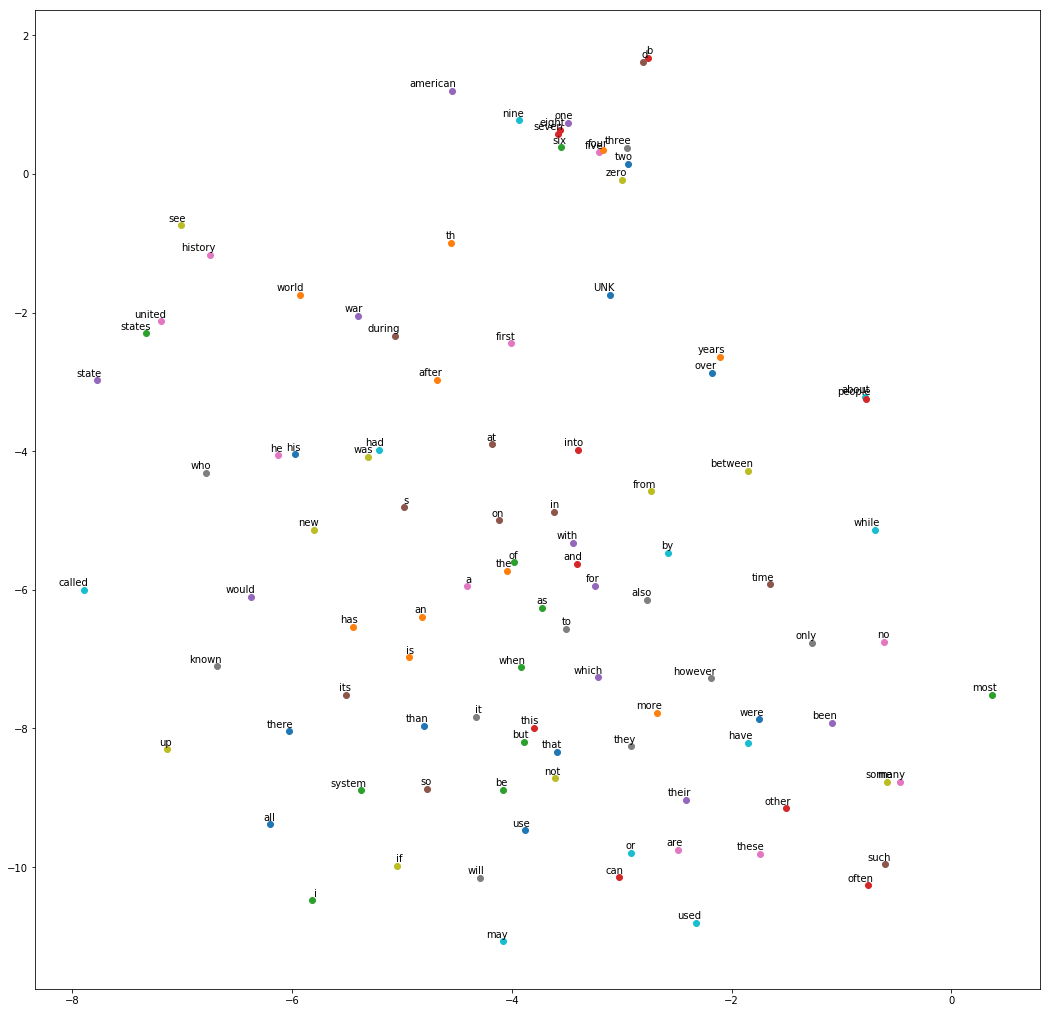

In [50]:
%matplotlib inline
# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

  plt.savefig(filename)


try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 100
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

## Evaluation
The below code uses the [kudkudak/word-embeddings-benchmarks package][1] to evaluate the above embeddings on the [Google Analogy test set][2].

 [1]: https://github.com/kudkudak/word-embeddings-benchmarks (Package for evaluating word embeddings)
 [2]: https://aclweb.org/aclwiki/Google_analogy_test_set_(State_of_the_art) (Google analogy test set)

In [51]:
from annoy import AnnoyIndex

n_trees = 10

annoy_index = AnnoyIndex(embedding_size, metric='dot')
for index, embedding in enumerate(final_embeddings):
    annoy_index.add_item(index, embedding)
annoy_index.build(n_trees)

True

In [52]:
from web.datasets.analogy import fetch_google_analogy

dataset = fetch_google_analogy()

In [53]:
from __future__ import division

previous_category = dataset.category[0]
trials = {'semantic': [], 'syntactic': [], 'total': []}
missing_words = set()
skipped_trials = 0

def print_acc():
    print('- Semantic accuracy:\t{} %\n- Syntactic accuracy:\t{} %\n- Total accuracy:\t{} %'.format(
        float('nan') if not trials['semantic'] else sum(trials['semantic']) / len(trials['semantic']) * 100,
        float('nan') if not trials['syntactic'] else sum(trials['syntactic']) / len(trials['syntactic']) * 100,
        float('nan') if not trials['total'] else sum(trials['total']) / len(trials['total']) * 100,
    ))
    print('- Missing words:\t{} (skipped {} % of all trials)'.format(
        ', '.join(missing_words),
        float('nan') if not trials['total'] else skipped_trials / len(trials['total']) * 100,
    ))
    print()

for X, y, category, category_high_level in zip(
            dataset.X,
            dataset.y,
            dataset.category,
            dataset.category_high_level
        ):

    if previous_category != category:
        previous_category = category
        print('Current category: {}'.format(category))
        print_acc()

    if X[0] in dictionary and X[1] in dictionary and X[2] in dictionary and y in dictionary:
        u1 = final_embeddings[dictionary[X[0]]]
        v1 = final_embeddings[dictionary[X[1]]]
        u2 = final_embeddings[dictionary[X[2]]]
        v2_index = annoy_index.get_nns_by_vector(u2 + (v1 - u1), 1)[0]
        v2_word = reverse_dictionary[v2_index]
        trial_success = v2_word == y
    else:
        if X[0] not in dictionary:
            missing_words.add(X[0])
        if X[1] not in dictionary:
            missing_words.add(X[1])
        if X[2] not in dictionary:
            missing_words.add(X[2])
        if y not in dictionary:
            missing_words.add(y)
        skipped_trials += 1
        trial_success = False
    trials[category_high_level].append(trial_success)
    trials['total'].append(trial_success)

print('Finished!')
print_acc()

Current category: capital-world
- Semantic accuracy:	0.0 %
- Syntactic accuracy:	nan %
- Total accuracy:	0.0 %
- Missing words:	 (skipped 0.0 % of all trials)

Current category: currency
- Semantic accuracy:	0.0 %
- Syntactic accuracy:	nan %
- Total accuracy:	0.0 %
- Missing words:	niamey, funafuti, thimphu, ashgabat (skipped 6.12326043738 % of all trials)

Current category: city-in-state
- Semantic accuracy:	0.0 %
- Syntactic accuracy:	nan %
- Total accuracy:	0.0 %
- Missing words:	niamey, funafuti, thimphu, ashgabat (skipped 5.22388059701 % of all trials)

Current category: family
- Semantic accuracy:	0.0 %
- Syntactic accuracy:	nan %
- Total accuracy:	0.0 %
- Missing words:	niamey, funafuti, thimphu, ashgabat (skipped 3.68288891546 % of all trials)

Current category: gram1-adjective-to-adverb
- Semantic accuracy:	0.0 %
- Syntactic accuracy:	nan %
- Total accuracy:	0.0 %
- Missing words:	niamey, funafuti, thimphu, ashgabat (skipped 3.4727703236 % of all trials)

Current category: gra